# <font color="green"> ПРОЕКТ №7. Аналитика в Яндекс.Афише </font>

# Цели и задачи проекта:
 - Загрузить данные и подготовь их к анализу
 - Построить отчёты и посчитать метрики
 - Сделать вывод: порекомендовать маркетологам, куда и сколько им стоит вкладывать денег?

# Входные данные:
1. Таблица **visits_log** (лог сервера с информацией о посещениях сайта):  
  - Uid / uid\* — уникальный идентификатор пользователя
  -	Device / device — категория устройства пользователя
  -	Start Ts / start_dt — дата и время начала сессии
  -	End Ts / end_dt — дата и время окончания сессии
  -	Source Id / source_id — идентификатор рекламного источника, из которого пришел пользователь  
    
    
2. Таблица **orders_log** (информация о заказах):
  -	Uid / uid — уникальный id пользователя, который сделал заказ
  -	Buy Ts / buy_dt — дата и время заказа
  -	Revenue / revenue — выручка Яндекс.Афиши с этого заказа  
     
     
3. Таблица **costs** (информация о затратах на маркетинг):
  -	source_id / source_id — идентификатор рекламного источника
  -	dt / dt — дата
  -	costs / costs — затраты на этот рекламный источник в этот день
  
  \* Названия столбцов указаны в формате "оригинальное название / измененное для обработки название"


<a name="0">-></a> 

# Содержание:   
  
  
<p>
<a href="#1.">1. Загрузка данных и подготовка их к анализу</a>
</p>
<p>
<div><a href="#2.">2. Отчеты и метрики</a></div>
<div><a href="#2.1.">&ensp;2.1. Продукт</a></div>
<div><a href="#2.1.1.">&ensp;&ensp;2.1.1. Сколько людей пользуются в день, неделю, месяц?</a></div>
<div><a href="#2.1.2.">&ensp;&ensp;2.1.2. Сколько сессий в день?</a></div>
<div><a href="#2.1.3.">&ensp;&ensp;2.1.3. Сколько длится одна сессия?</a></div>
<div><a href="#2.1.4.">&ensp;&ensp;2.1.4. Как часто люди возвращаются?</a></div>
<div><a href="#2.2.">&ensp;2.2. Продажи</a></div>
<div><a href="#2.2.1.">&ensp;&ensp;2.2.1. Когда люди начинают покупать?</a></div>
<div><a href="#2.2.2.">&ensp;&ensp;2.2.2. Сколько раз покупают за период?</a></div>
<div><a href="#2.2.3.">&ensp;&ensp;2.2.3. Какой средний чек?</a></div>
<div><a href="#2.2.4.">&ensp;&ensp;2.2.4. Сколько денег приносят? (LTV)</a></div>
<div><a href="#2.3.">&ensp;2.3. Маркетинг</a></div>
<div><a href="#2.3.1.">&ensp;&ensp;2.3.1. Сколько денег потратили? Всего / на каждый источник / по времени</a></div>
<div><a href="#2.3.2.">&ensp;&ensp;2.3.2. Сколько стоило привлечение одного покупателя из каждого источника?</a></div>
<div><a href="#2.3.3.">&ensp;&ensp;2.3.3. Насколько окупились расходы? (ROI)</a></div>
</p>
<p>
<a href="#3.">3. Выводы</a>
</p>


In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
#from tqdm.notebook import tqdm
#tqdm.pandas()

In [2]:
#Жирный шрифт
BOLD_TEXT = '\033[1m'

In [3]:
#Функция рисования тепловой карты
def show_heatmap(title, pivot_table, vmax):
    sns.set(style='white')
    plt.figure(figsize=(16,9))
    plt.title(title)
    heat_map = sns.heatmap(pivot_table,
               annot = True,
               fmt = '.2f',
               linewidth = 1,
               linecolor = 'gray',
               vmax = vmax)
    heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)

<a name="1.">-></a> 
<a href="#0">К содержанию</a>

# 1. Загрузка данных и подготовка к анализу

## 1.1. Загрузка данных и предварительный анализ

*Загружаю датасеты:*

In [4]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

*Объявлю словарь с загруженными датасетами:*

In [5]:
datasets_dict = {'visits':visits, 'orders':orders, 'costs':costs}

*Покажу случайные строки датафреймов:*

In [6]:
for name in datasets_dict.keys():
    print(datasets_dict[name].sample())
    print('\n\n','-'*80)

         Device               End Ts  Source Id             Start Ts  \
141822  desktop  2017-12-19 21:42:00          2  2017-12-19 21:38:00   

                         Uid  
141822  15835699863511229389  


 --------------------------------------------------------------------------------
                   Buy Ts  Revenue                 Uid
2108  2017-06-27 21:29:00     1.83  122714190337620840


 --------------------------------------------------------------------------------
      source_id          dt   costs
1593          5  2017-10-20  189.67


 --------------------------------------------------------------------------------


*Нет необходимости в выводе подробных данных(**describe**). Покажу только основную информацию по датасетам (число строк, пропусков и тип данных):*

In [7]:
def show_common_df_info():
    all_datasets_info = pd.DataFrame()
    for name in datasets_dict.keys():
        dataset_info = pd.DataFrame()
        dataset_info['data_type'] = datasets_dict[name].dtypes
        dataset_info['na_number'] = datasets_dict[name].isna().sum()
        dataset_info['rows_number'] = datasets_dict[name].count()
        dataset_info['df_name'] = name
        dataset_info['df_column'] = dataset_info.index
        dataset_info = dataset_info.groupby(['df_name','rows_number','df_column'])['data_type', 'na_number'].min()
        all_datasets_info = pd.concat([all_datasets_info, dataset_info])
    return all_datasets_info

In [8]:
show_common_df_info()

data_type  na_number
df_name rows_number df_column                     
visits  359400      Device       object          0
                    End Ts       object          0
                    Source Id     int64          0
                    Start Ts     object          0
                    Uid          uint64          0
orders  50415       Buy Ts       object          0
                    Revenue     float64          0
                    Uid          uint64          0
costs   2542        costs       float64          0
                    dt           object          0
                    source_id     int64          0

**Выводы**: *Для дальнейшего анализа исправлю следующее:*
 - *Поменяю имена столбцов на более удобные в таблицах **visits** и **orders**.*
 - *Изменю тип данных на **datetime** во всех столбцах с датами:*

## 1.2. Подготовка к анализу

*Изменю названия столбцов в таблицах **visits** и **orders**:*

In [9]:
visits.set_axis(['device','end_dt','source_id','start_dt','uid'], axis=1, inplace=True)
orders.set_axis(['buy_dt','revenue','uid'], axis=1, inplace=True)

*Проверка:*

In [10]:
visits.columns, orders.columns

(Index(['device', 'end_dt', 'source_id', 'start_dt', 'uid'], dtype='object'),
 Index(['buy_dt', 'revenue', 'uid'], dtype='object'))

*Изменю тип данных на **datetime** во всех столбцах с датами:*

In [11]:
visits['end_dt'] = pd.to_datetime(visits['end_dt'], format='%Y-%m-%d %H:%M:%S')
visits['start_dt'] = pd.to_datetime(visits['start_dt'], format='%Y-%m-%d %H:%M:%S')
orders['buy_dt'] = pd.to_datetime(orders['buy_dt'], format='%Y-%m-%d %H:%M:%S')
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

*Проверка:*

In [12]:
show_common_df_info()

data_type  na_number
df_name rows_number df_column                           
visits  359400      device             object          0
                    end_dt     datetime64[ns]          0
                    source_id           int64          0
                    start_dt   datetime64[ns]          0
                    uid                uint64          0
orders  50415       buy_dt     datetime64[ns]          0
                    revenue           float64          0
                    uid                uint64          0
costs   2542        costs             float64          0
                    dt         datetime64[ns]          0
                    source_id           int64          0

*Также в таблице с заказами есть всего одна покупка в последний месяц наблюдения:*

In [13]:
orders.query('buy_dt >= "2018-06-01"')

,buy_dt,revenue,uid
50414,2018-06-01 00:02:00,3.42,83872787173869366


*Удалю эту строку, чтобы она не портила вывод информации:*

In [14]:
index = orders.loc[orders['buy_dt'] >= "2018-06-01"].index[0]

In [15]:
orders.drop(labels=index, inplace=True)
orders.reset_index().head(1)

,index,buy_dt,revenue,uid
0,0,2017-06-01 00:10:00,17.0,10329302124590727494


<a name="2.">-></a> 
<a href="#0">К содержанию</a>

# 2. Отчеты и метрики

<a name="2.1.">-></a> 
<a href="#0">К содержанию</a>

## 2.1. Продукт

<a name="2.1.1.">-></a> 
<a href="#0">К содержанию</a>

### 2.1.1. Сколько людей пользуются в день, неделю, месяц?

#### 2.1.1.1. Среднее количество уникальных пользователь в день, неделю, месяц.

*Сгруппирую таблицу с визитами по устройствам и источникам рекламы и посчитаю количество уникальных пользователей:*

In [16]:
users_by_devices_and_sources = visits.groupby(['device','source_id']).agg({'uid':'nunique'})
users_by_devices_and_sources.rename(columns={'uid':'unique_users'}, inplace=True)

*Посчитаю количество дней, недель и месяцев в интервале наблюдения, отраженном в таблице с визитами:* 

In [17]:
total_days = round((visits['start_dt'].max() - visits['start_dt'].min()) / np.timedelta64(1,'D'))
total_weeks = round((visits['start_dt'].max() - visits['start_dt'].min()) / np.timedelta64(1,'W'))
total_months = round((visits['start_dt'].max() - visits['start_dt'].min()) / np.timedelta64(1,'M'))

*Добавлю столбцы со средними количествами посещений за день, неделю и месяц:*

In [18]:
users_by_devices_and_sources['unique_users_in_day'] = round(users_by_devices_and_sources['unique_users'] 
                                                         / total_days).astype('int')
users_by_devices_and_sources['unique_users_in_week'] = round(users_by_devices_and_sources['unique_users'] 
                                                          / total_weeks).astype('int')
users_by_devices_and_sources['unique_users_in_month'] = round(users_by_devices_and_sources['unique_users'] 
                                                           / total_months).astype('int')
users_by_devices_and_sources

unique_users  unique_users_in_day  unique_users_in_week  \
device  source_id                                                            
desktop 1                 13172                   36                   253   
        2                 18257                   50                   351   
        3                 57420                  157                  1104   
        4                 55607                  152                  1069   
        5                 42053                  115                   809   
        6                     5                    0                     0   
        7                    26                    0                     0   
        9                  7079                   19                   136   
        10                 5763                   16                   111   
touch   1                  6094                   17                   117   
        2                  8609                   24                   166   
        3                 18600                   51                   358   
        4                 29313                   80                   564   
        5                 15375                   42                   296   
        6                     1                    0                     0   
        7                     8                    0                     0   
        9                  2402                    7                    46   
        10                 2381                    7                    46   

                   unique_users_in_month  
device  source_id                         
desktop 1                           1098  
        2                           1521  
        3                           4785  
        4                           4634  
        5                           3504  
        6                              0  
        7                              2  
        9                            590  
        10                           480  
touch   1                            508  
        2                            717  
        3                           1550  
        4                           2443  
        5                           1281  
        6                              0  
        7                              1  
        9                            200  
        10                           198

*Нарисую диаграмму по посещениям за день:*

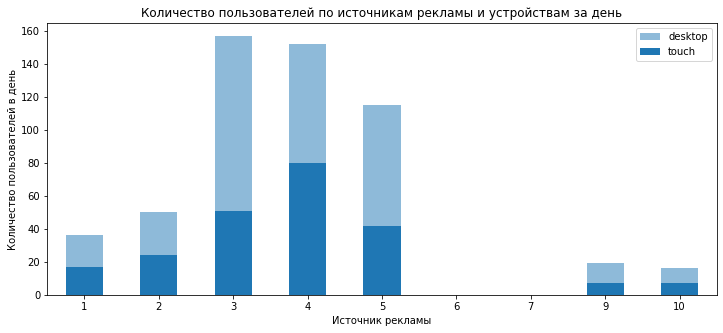

In [19]:
df = users_by_devices_and_sources.reset_index()
ax = df.query('device == "desktop"').plot(kind='bar', y='unique_users_in_day', x = 'source_id', alpha=0.5, rot=0)
df.query('device == "touch"').plot(kind='bar', y='unique_users_in_day', x = 'source_id', ax = ax, rot=0, figsize=(12,5))
ax.set_title('Количество пользователей по источникам рекламы и устройствам за день')
ax.set_ylabel('Количество пользователей в день')
ax.set_xlabel('Источник рекламы')
ax.legend(['desktop','touch'])

*Нарисую диаграмму по посещениям за неделю:*

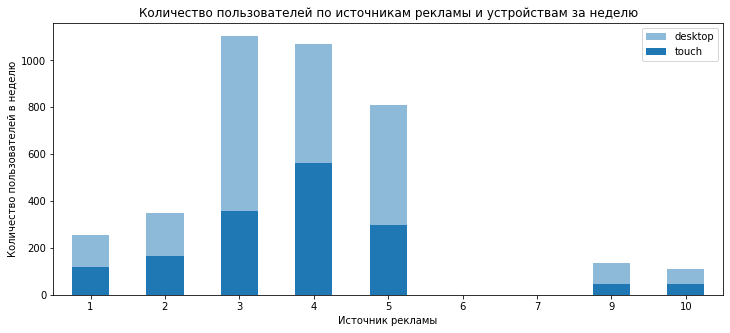

In [20]:
ax = df.query('device == "desktop"').plot(kind='bar', y='unique_users_in_week', x = 'source_id', alpha=0.5, rot=0)
df.query('device == "touch"').plot(kind='bar', y='unique_users_in_week', x = 'source_id', ax = ax, rot=0, figsize=(12,5))
ax.set_title('Количество пользователей по источникам рекламы и устройствам за неделю')
ax.set_ylabel('Количество пользователей в неделю')
ax.set_xlabel('Источник рекламы')
ax.legend(['desktop','touch'])

*Нарисую диаграмму по посещениям за месяц:*

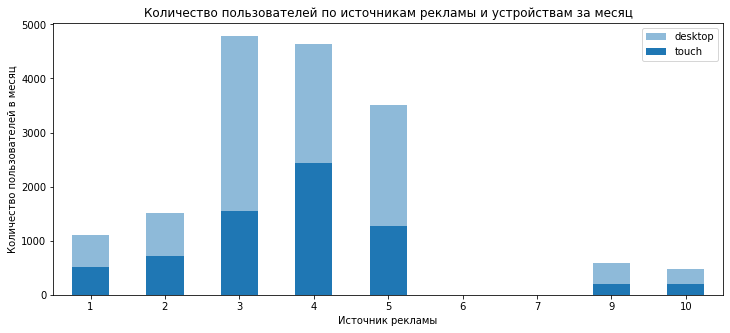

In [21]:
ax = df.query('device == "desktop"').plot(kind='bar', y='unique_users_in_month', x = 'source_id', alpha=0.5, rot=0)
df.query('device == "touch"').plot(kind='bar', y='unique_users_in_month', x = 'source_id', ax = ax, rot=0, figsize=(12,5))
ax.set_title('Количество пользователей по источникам рекламы и устройствам за месяц')
ax.set_ylabel('Количество пользователей в месяц')
ax.set_xlabel('Источник рекламы')
ax.legend(['desktop','touch'])

#### <font color="blue"> 2.1.1.2. Изменение DAU, WAU и MAU по дням, неделям и месяцам</font>


*Добавлю столбцы с днем, неделей и месяцем визита:*

In [22]:
visits['day'] = visits['start_dt'].astype('datetime64[D]')
visits['week'] = (
    visits['start_dt'].astype('datetime64[D]') - 
    pd.to_timedelta(visits['start_dt'].dt.dayofweek, unit='d')
)
visits['month'] = visits['start_dt'].astype('datetime64[M]')
visits.head(3)

,device,end_dt,source_id,start_dt,uid,day,week,month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-18,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-26,2017-07-01


*Сгруппирую по дню и нарисую график:*

In [23]:
visits_dau = visits.groupby('day').agg({'uid':'nunique'})

Text(0.5, 0, 'Дата')

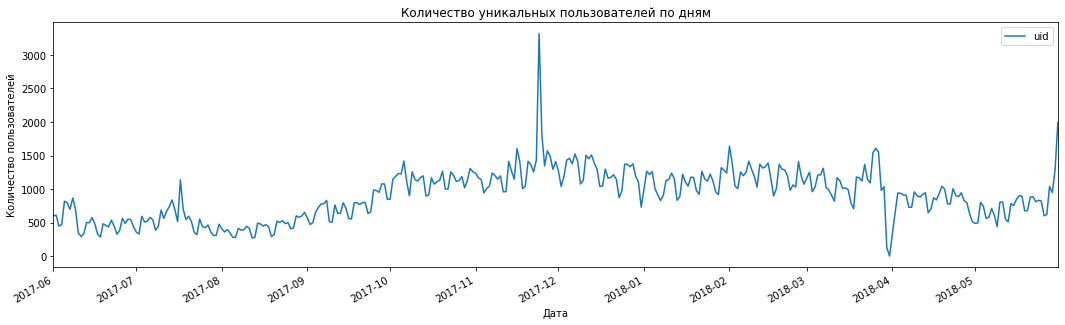

In [24]:
ax = visits_dau.plot(kind='line', figsize=(18,5))
ax.set_title('Количество уникальных пользователей по дням')
ax.set_ylabel('Количество пользователей')
ax.set_xlabel('Дата')

*На графике видны экстремальные значений. Покажу даты самых высоких и низких значений:*

In [25]:
visits_dau.sort_values(by='uid')

,uid
day,
2018-03-31,1
2018-03-30,131
2017-08-12,271
2017-08-05,280
2017-08-13,281
...,...
2018-03-26,1609
2018-02-01,1640
2017-11-25,1817


*Есть сильный спад 2018-03-30 и 2018-03-31. Возможно, у Сервиса тогда были тех.проблемы. Так же заметен пик 2017-11-24. Проверю, не связан ли он с деятельностью одного пользователя:*

In [26]:
visits.query('day == "2017-11-24"')['uid'].value_counts().head(3)

1457537016336779203     7
10403169074343195591    6
9717719112529363193     6
Name: uid, dtype: int64

*Нет, не связан. Вероятно, в тот день была акция или открыли продажу билетов на какое-то уникальное событие.*

*Сгруппирую по неделе и нарисую график:*

In [27]:
visits_wau = visits.groupby('week').agg({'uid':'nunique'})

Text(0.5, 0, 'Неделя')

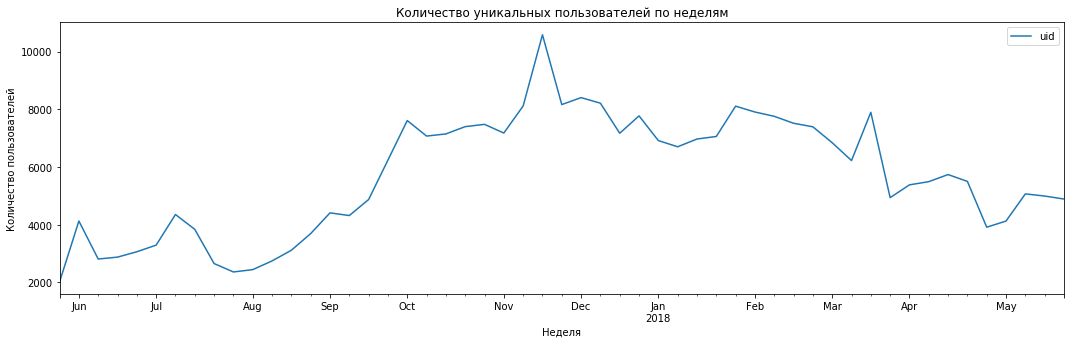

In [28]:
ax = visits_wau.plot(kind='line', figsize=(18,5))
ax.set_title('Количество уникальных пользователей по неделям')
ax.set_ylabel('Количество пользователей')
ax.set_xlabel('Неделя')

*Сгруппирую по месяцу и нарисую график:*

In [29]:
visits_mau = visits.groupby('month').agg({'uid':'nunique'})

Text(0.5, 0, 'Месяц')

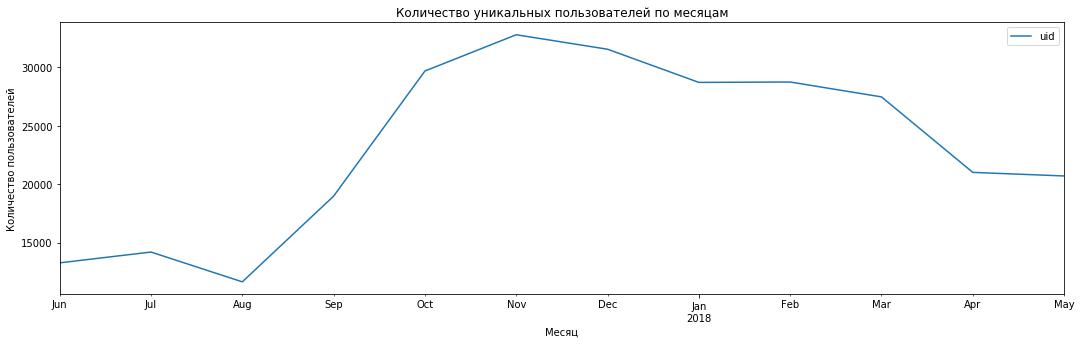

In [30]:
ax = visits_mau.plot(kind='line', figsize=(18,5))
ax.set_title('Количество уникальных пользователей по месяцам')
ax.set_ylabel('Количество пользователей')
ax.set_xlabel('Месяц')

*Как видно из графика, холодные месяцы - самые активные. Также заметен спад в последние недели августа. Видимо, родителям школьников и студентам не до развлечений в эти дни.*

**Выводы:** 
 - *Со стационарных устройств заходят больше пользователей. Кроме рекламного источника 4. Тут есть небольшой перевес в пользу мобильных устройств*
 - *Холодные месяцы - самые активные*
 - *Конец августа - самый низкий по посещениям период*
 - *Есть сильный спад 2018-03-30 и 2018-03-31. Возможно, у Сервиса тогда были тех.проблемы. Так же заметен пик 2017-11-24, связанный, вероятно, с какой-то акцией*

<a name="2.1.2.">-></a> 
<a href="#0">К содержанию</a>

### 2.1.2. Сколько сессий в день?

#### 2.1.2.1. Среднее число сессий в день по устройствам и источникам рекламы

*Сгруппирую таблицу с визитами по устройствам и источникам рекламы и посчитаю количество сессий:*

In [31]:
sessions_by_devices_and_sources = visits.groupby(['device','source_id']).agg({'uid':'count'})
sessions_by_devices_and_sources.rename(columns={'uid':'sessions_number'}, inplace=True)

*Добавлю столбец со средними количествами посещений за день:*

In [32]:
sessions_by_devices_and_sources['sessions_in_day'] = round(sessions_by_devices_and_sources['sessions_number'] 
                                                         / total_days).astype('int')
sessions_by_devices_and_sources

sessions_number  sessions_in_day
device  source_id                                  
desktop 1                    25901               71
        2                    35661               98
        3                    65777              180
        4                    67640              185
        5                    50069              137
        6                        5                0
        7                       28                0
        9                    10119               28
        10                    7367               20
touch   1                     8220               23
        2                    11965               33
        3                    19833               54
        4                    34154               94
        5                    16836               46
        6                        1                0
        7                        8                0
        9                     3158                9
        10                    2658                7

*Нарисую диаграмму по сессиям за день:*

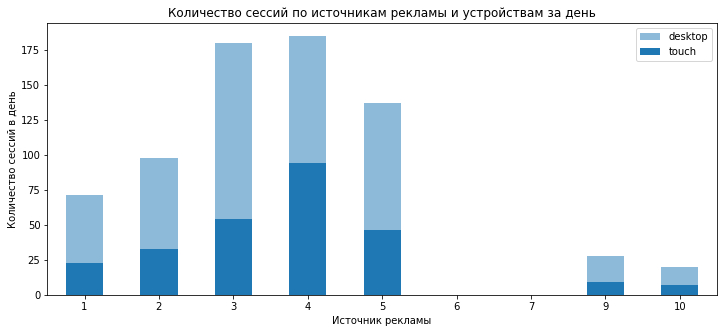

In [33]:
df = sessions_by_devices_and_sources.reset_index()
ax = df.query('device == "desktop"').plot(kind='bar', y='sessions_in_day', x = 'source_id', alpha=0.5, rot=0)
df.query('device == "touch"').plot(kind='bar', y='sessions_in_day', x = 'source_id', ax = ax, rot=0, figsize=(12,5))
ax.set_title('Количество сессий по источникам рекламы и устройствам за день')
ax.set_ylabel('Количество сессий в день')
ax.set_xlabel('Источник рекламы')
ax.legend(['desktop','touch'])
#visits_by_devices_and_sources.plot(kind='bar', y='sessions_in_day')

#### 2.1.2.2. Среднее число сессий в день по устройствам и месяцам

*Создам столбец с месяцем а таблице с визитами:*

In [34]:
visits['session_month'] = visits['start_dt'].astype('datetime64[M]')

*Сгруппирую таблицу с визитами по устройствам и месяцам и посчитаю количество сессий:*

In [35]:
sessions_by_devices_and_months = visits.groupby(['device','session_month']).agg({'uid':'count'})
sessions_by_devices_and_months.rename(columns={'uid':'sessions_number'}, inplace=True)

*Добавлю столбец со средними количествами посещений за день:*

In [36]:
sessions_by_devices_and_months['sessions_in_day'] = round(12*sessions_by_devices_and_months['sessions_number'] 
                                                         / 365).astype('int')
sessions_by_devices_and_months

sessions_number  sessions_in_day
device  session_month                                  
desktop 2017-06-01               12358              406
        2017-07-01               12950              426
        2017-08-01               10854              357
        2017-09-01               17356              571
        2017-10-01               27392              901
        2017-11-01               32917             1082
        2017-12-01               31112             1023
        2018-01-01               26577              874
        2018-02-01               27077              890
        2018-03-01               25861              850
        2018-04-01               19231              632
        2018-05-01               18882              621
touch   2017-06-01                4147              136
        2017-07-01                4878              160
        2017-08-01                3501              115
        2017-09-01                6551              215
        2017-10-01               10511              346
        2017-11-01               11052              363
        2017-12-01               10871              357
        2018-01-01               10362              341
        2018-02-01               10105              332
        2018-03-01                9818              323
        2018-04-01                7284              239
        2018-05-01                7753              255

*Нарисую диаграмму по сессиям за день:*

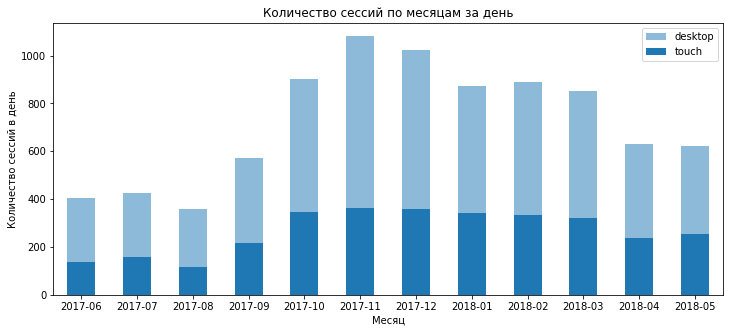

In [37]:
df = sessions_by_devices_and_months.reset_index()
df['session_month'] = df['session_month'].dt.strftime('%Y-%m')
ax = df.query('device == "desktop"').plot(kind='bar', x = 'session_month', y='sessions_in_day', alpha=0.5, rot=0)
df.query('device == "touch"').plot(kind='bar', x = 'session_month', y='sessions_in_day', ax = ax, rot=0, figsize=(12,5))
ax.set_title('Количество сессий по месяцам за день')
ax.set_ylabel('Количество сессий в день')
ax.set_xlabel('Месяц')
ax.legend(['desktop','touch'])
#visits_by_devices_and_sources.plot(kind='bar', y='sessions_in_day')

**Выводы:** *Сессий со стационарных устройств больше*

<a name="2.1.3.">-></a> 
<a href="#0">К содержанию</a>

### 2.1.3. Сколько длится одна сессия?

*Для поиска данного значения не буду группировать по рекламным источникам и месяцам. Рассмотрю только различие по устройствам.  
Добавлю новый столбец с продолжительностью сессии:*

In [38]:
visits['session_duration'] = (visits['end_dt'] - visits['start_dt']).dt.seconds

*Нарисую гистограмму для стационарных устройств:*

Text(0.5, 0, 'Продолжительность сессии, сек')

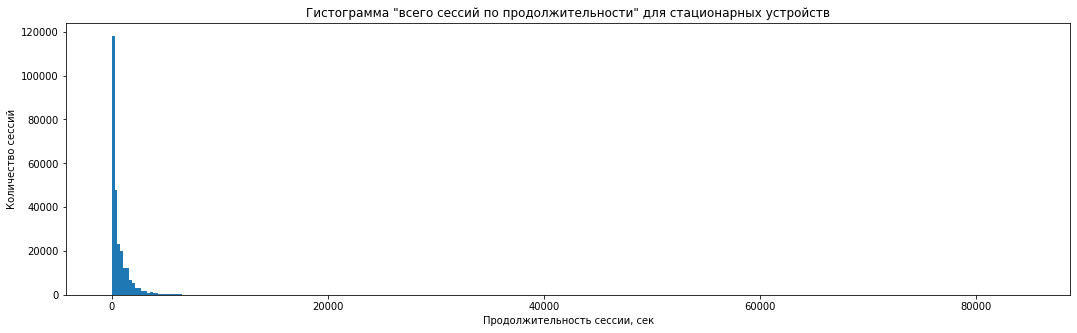

In [39]:
bins_number = len(visits['session_duration'].unique())
ax = visits.query('device =="desktop"')['session_duration'].plot(kind='hist', figsize=(18,5), bins=bins_number)
ax.set_title('Гистограмма "всего сессий по продолжительности" для стационарных устройств')
ax.set_ylabel('Количество сессий')
ax.set_xlabel('Продолжительность сессии, сек')

*Распределение далеко от нормального. Для подсчета усредненного значения использую моду:*

In [40]:
mean_session_duration_desktop = visits.query('device == "desktop"')['session_duration'].mode()[0]

*Нарисую гистограмму ля стационарных устройств:*

Text(0.5, 0, 'Продолжительность сессии, сек')

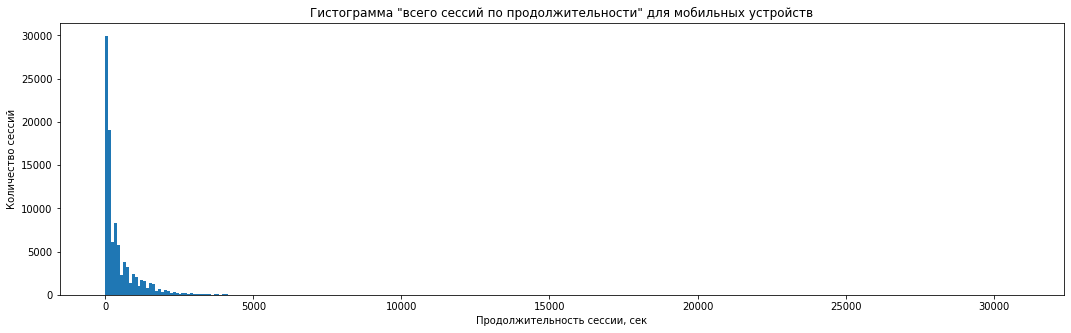

In [41]:
bins_number = len(visits['session_duration'].unique())
ax = visits.query('device =="touch"')['session_duration'].plot(kind='hist', figsize=(18,5), bins=bins_number)
ax.set_title('Гистограмма "всего сессий по продолжительности" для мобильных устройств')
ax.set_ylabel('Количество сессий')
ax.set_xlabel('Продолжительность сессии, сек')

*Распределение далеко от нормального. Для подсчета усредненного значения использую моду:*

In [42]:
mean_session_duration_touch = visits.query('device == "touch"')['session_duration'].mode()[0]

*Также по диаграммам заметно различие в продолжительности сессий с разных устройств. Найду отношение медиан по этим источникам:*

In [43]:
mean_session_duration_median_ratio = (
    visits.query('device == "desktop"')['session_duration'].median() /
    visits.query('device == "touch"')['session_duration'].median()   
)

**Вывод:**

In [44]:
print(BOLD_TEXT + 'Самая частая продолжительность сессии со стационарных устройств: {} секунд'
      .format(mean_session_duration_desktop))
print(BOLD_TEXT + 'Самая частая продолжительность сессии с мобильных устройств: {} секунд'
      .format(mean_session_duration_touch))
print(BOLD_TEXT + 'Средняя продолжительность сессии со стационарных устройств больше таковой с мобильных устройств в {} раз'
      .format(mean_session_duration_median_ratio))

Самая частая продолжительность сессии со стационарных устройств: 60 секунд
Самая частая продолжительность сессии с мобильных устройств: 60 секунд
Средняя продолжительность сессии со стационарных устройств больше таковой с мобильных устройств в 2.0 раз


<a name="2.1.4.">-></a> 
<a href="#0">К содержанию</a>

### 2.1.4. Как часто люди возвращаются?

*Для данного задания не буду группировать по рекламным источникам, т.к. для возвращения на ресурс не важно, откуда пришел пользователь. Посчитаю коэффициенты удержания по когортам для разных типов устройств и для всех вместе. Разница в результатах может, например, косвенно указать на различие в удобстве интерфейса для обеих платформ. В качестве когорты приму группу пользователей, впервые посетивших Яндекс.Афиша в один месяц. Использую эту таблицу:*

In [45]:
visits.head(3)

,device,end_dt,source_id,start_dt,uid,day,week,month,session_month,session_duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-18,2017-12-01,2017-12-01,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,2018-02-01,2018-02-01,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-26,2017-07-01,2017-07-01,0


#### 2.1.4.1. Пользователи стационарных устройств

*Найду месяцы первых визитов пользователей:*

In [46]:
visits_by_desktop = visits.query('device == "desktop"')

In [47]:
first_visits = visits_by_desktop.groupby('uid').agg({'session_month':'min'}).reset_index()
first_visits.rename(columns={'session_month':'first_session_month'}, inplace=True)
first_visits.head(3)

,uid,first_session_month
0,297729379853735,2017-06-01
1,313578113262317,2017-09-01
2,325320750514679,2017-09-01


*Из полученной таблицы найду численность когорт:*

In [48]:
cohorts_sizes = first_visits.groupby('first_session_month').agg({'uid':'nunique'}).reset_index()
cohorts_sizes.rename(columns={'uid':'cohort_size'}, inplace=True)
cohorts_sizes.head(3)

,first_session_month,cohort_size
0,2017-06-01,9761
1,2017-07-01,9374
2,2017-08-01,7532


*Объявлю новую таблицу с визитами:*

In [49]:
visits_new = visits_by_desktop[['uid','session_month']].merge(first_visits, on='uid')
visits_new.head(3)

,uid,session_month,first_session_month
0,104060357244891740,2018-02-01,2018-02-01
1,16174680259334210214,2018-05-01,2018-03-01
2,16174680259334210214,2018-03-01,2018-03-01


*Найду количество уникальных членов когорт по месяцам (lifetime) и добавлю численность когорт:*

In [50]:
cohorts_sizes_by_month = visits_new.groupby(['first_session_month','session_month']).agg({'uid':'nunique'}).reset_index()
cohorts_sizes_by_month = cohorts_sizes_by_month.merge(cohorts_sizes, on='first_session_month')
cohorts_sizes_by_month.rename(columns={'uid':'group_size'}, inplace=True)
cohorts_sizes_by_month.head(3)

,first_session_month,session_month,group_size,cohort_size
0,2017-06-01,2017-06-01,9761,9761
1,2017-06-01,2017-07-01,771,9761
2,2017-06-01,2017-08-01,541,9761


*Посчитаю коэффициенты удержания:*

In [51]:
cohorts_sizes_by_month['retention_rate'] = (
    100 * cohorts_sizes_by_month['group_size'] / cohorts_sizes_by_month['cohort_size']
).round(2)
cohorts_sizes_by_month.head(3)

,first_session_month,session_month,group_size,cohort_size,retention_rate
0,2017-06-01,2017-06-01,9761,9761,100.00
1,2017-06-01,2017-07-01,771,9761,7.90
2,2017-06-01,2017-08-01,541,9761,5.54


*Заменю столбец с месяцем сессии на указатель lifetime и упрощу названия когорт:*

In [52]:
cohorts_sizes_by_month['session_month'] = (
    (cohorts_sizes_by_month['session_month'] - cohorts_sizes_by_month['first_session_month']) /
    np.timedelta64(1,'M')
).round().astype('int')
cohorts_sizes_by_month.rename(columns={'session_month':'cohort_lifetime'}, inplace=True)
cohorts_sizes_by_month['first_session_month'] = cohorts_sizes_by_month['first_session_month'].dt.strftime('%Y-%m')
cohorts_sizes_by_month.head(3)

,first_session_month,cohort_lifetime,group_size,cohort_size,retention_rate
0,2017-06,0,9761,9761,100.00
1,2017-06,1,771,9761,7.90
2,2017-06,2,541,9761,5.54


*Сводная таблица с данными о коэффициенте удержания по когортам и lifetime:*

In [53]:
retention_per_cohort_pivot_desktop = cohorts_sizes_by_month.pivot_table(
    index = 'first_session_month',
    columns = 'cohort_lifetime',
    values='retention_rate'
)
retention_per_cohort_pivot_desktop.head(3)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06,100.0,7.90,5.54,6.35,6.95,7.43,6.11,5.86,5.38,5.03,4.08,4.37
2017-07,100.0,5.74,5.14,5.57,5.87,4.69,4.58,4.42,3.84,2.90,2.47,NaN
2017-08,100.0,7.55,6.27,6.29,5.19,4.26,3.48,3.82,2.96,2.76,NaN,NaN


*Максимальное значение коэффициента:*

In [54]:
rr_max = retention_per_cohort_pivot_desktop.loc[:,1:].max().max()

<font color="blue"> Скорректировал цветовую гамму карт</font>


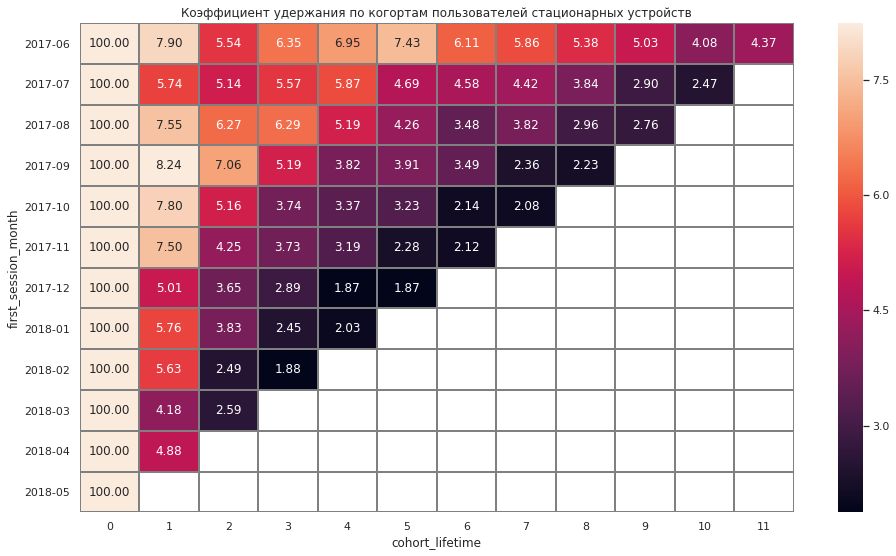

In [55]:
show_heatmap('Коэффициент удержания по когортам пользователей стационарных устройств', 
             retention_per_cohort_pivot_desktop, rr_max)

#### 2.1.4.2. Пользователи мобильных устройств

*Найду месяцы первых визитов пользователей:*

In [56]:
visits_by_touch = visits.query('device == "touch"')

In [57]:
first_visits = visits_by_touch.groupby('uid').agg({'session_month':'min'}).reset_index()
first_visits.rename(columns={'session_month':'first_session_month'}, inplace=True)
first_visits.head(3)

,uid,first_session_month
0,11863502262781,2018-03-01
1,49537067089222,2018-02-01
2,397399764396656,2018-01-01


*Из полученной таблицы найду численность когорт:*

In [58]:
cohorts_sizes = first_visits.groupby('first_session_month').agg({'uid':'nunique'}).reset_index()
cohorts_sizes.rename(columns={'uid':'cohort_size'}, inplace=True)
cohorts_sizes.head(3)

,first_session_month,cohort_size
0,2017-06-01,3655
1,2017-07-01,4036
2,2017-08-01,2865


*Объявлю новую таблицу с визитами:*

In [59]:
visits_new = visits_by_touch[['uid','session_month']].merge(first_visits, on='uid')
visits_new.head(3)

,uid,session_month,first_session_month
0,16879256277535980062,2017-12-01,2017-12-01
1,7459035603376831527,2017-07-01,2017-07-01
2,11423865690854540312,2017-11-01,2017-11-01


*Найду количество уникальных членов когорт по месяцам (lifetime) и добавлю численность когорт:*

In [60]:
cohorts_sizes_by_month = visits_new.groupby(['first_session_month','session_month']).agg({'uid':'nunique'}).reset_index()
cohorts_sizes_by_month = cohorts_sizes_by_month.merge(cohorts_sizes, on='first_session_month')
cohorts_sizes_by_month.rename(columns={'uid':'group_size'}, inplace=True)
cohorts_sizes_by_month.head(3)

,first_session_month,session_month,group_size,cohort_size
0,2017-06-01,2017-06-01,3655,3655
1,2017-06-01,2017-07-01,187,3655
2,2017-06-01,2017-08-01,112,3655


*Посчитаю коэффициенты удержания:*

In [61]:
cohorts_sizes_by_month['retention_rate'] = (
    100 * cohorts_sizes_by_month['group_size'] / cohorts_sizes_by_month['cohort_size']
).round(2)
cohorts_sizes_by_month.head(3)

,first_session_month,session_month,group_size,cohort_size,retention_rate
0,2017-06-01,2017-06-01,3655,3655,100.00
1,2017-06-01,2017-07-01,187,3655,5.12
2,2017-06-01,2017-08-01,112,3655,3.06


*Заменю столбец с месяцем сессии на указатель lifetime и упрощу названия когорт:*

In [62]:
cohorts_sizes_by_month['session_month'] = (
    (cohorts_sizes_by_month['session_month'] - cohorts_sizes_by_month['first_session_month']) /
    np.timedelta64(1,'M')
).round().astype('int')
cohorts_sizes_by_month.rename(columns={'session_month':'cohort_lifetime'}, inplace=True)
cohorts_sizes_by_month['first_session_month'] = cohorts_sizes_by_month['first_session_month'].dt.strftime('%Y-%m')
cohorts_sizes_by_month.head(3)

,first_session_month,cohort_lifetime,group_size,cohort_size,retention_rate
0,2017-06,0,3655,3655,100.00
1,2017-06,1,187,3655,5.12
2,2017-06,2,112,3655,3.06


*Сводная таблица с данными о коэффициенте удержания по когортам и lifetime:*

In [63]:
retention_per_cohort_pivot_touch = cohorts_sizes_by_month.pivot_table(
    index = 'first_session_month',
    columns = 'cohort_lifetime',
    values='retention_rate'
)
retention_per_cohort_pivot_touch.head(3)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06,100.0,5.12,3.06,3.39,4.16,3.39,3.01,2.87,2.52,2.35,1.86,2.44
2017-07,100.0,3.84,3.17,3.59,3.47,2.95,2.45,2.58,2.28,1.59,1.61,NaN
2017-08,100.0,5.97,4.68,4.26,3.04,3.14,2.65,2.79,1.22,1.33,NaN,NaN


*Максимальное значение коэффициента:*

In [64]:
rr_max = retention_per_cohort_pivot_touch.loc[:,1:].max().max()

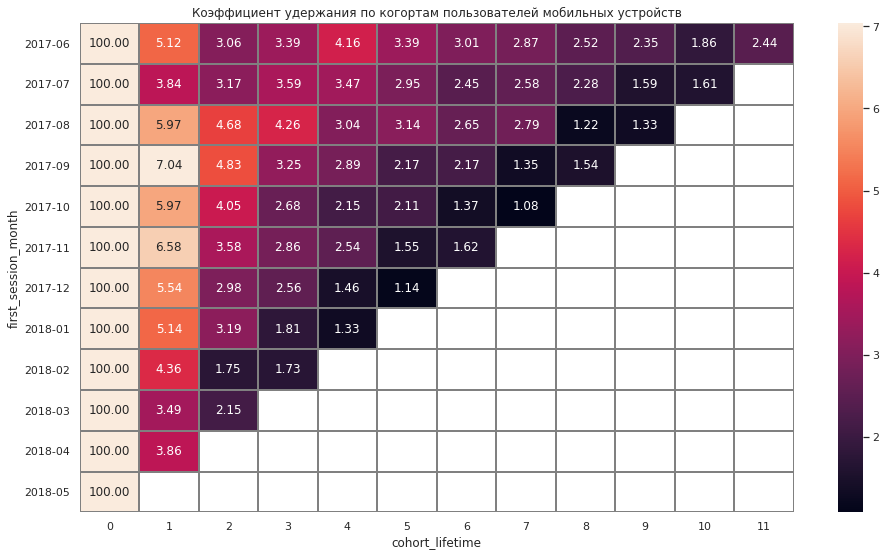

In [65]:
show_heatmap('Коэффициент удержания по когортам пользователей мобильных устройств', 
             retention_per_cohort_pivot_touch, rr_max)

#### 2.1.4.3. Пользователи всех устройств

*Найду месяцы первых визитов пользователей:*

In [66]:
first_visits = visits.groupby('uid').agg({'session_month':'min'}).reset_index()
first_visits.rename(columns={'session_month':'first_session_month'}, inplace=True)
first_visits.head(3)

,uid,first_session_month
0,11863502262781,2018-03-01
1,49537067089222,2018-02-01
2,297729379853735,2017-06-01


*Из полученной таблицы найду численность когорт:*

In [67]:
cohorts_sizes = first_visits.groupby('first_session_month').agg({'uid':'nunique'}).reset_index()
cohorts_sizes.rename(columns={'uid':'cohort_size'}, inplace=True)
cohorts_sizes.head(3)

,first_session_month,cohort_size
0,2017-06-01,13259
1,2017-07-01,13140
2,2017-08-01,10181


*Объявлю новую таблицу с визитами:*

In [68]:
visits_new = visits[['uid','session_month']].merge(first_visits, on='uid')
visits_new.head(3)

,uid,session_month,first_session_month
0,16879256277535980062,2017-12-01,2017-12-01
1,104060357244891740,2018-02-01,2018-02-01
2,7459035603376831527,2017-07-01,2017-07-01


*Найду количество уникальных членов когорт по месяцам (lifetime) и добавлю численность когорт:*

In [69]:
cohorts_sizes_by_month = visits_new.groupby(['first_session_month','session_month']).agg({'uid':'nunique'}).reset_index()
cohorts_sizes_by_month = cohorts_sizes_by_month.merge(cohorts_sizes, on='first_session_month')
cohorts_sizes_by_month.rename(columns={'uid':'group_size'}, inplace=True)
cohorts_sizes_by_month.head(3)

,first_session_month,session_month,group_size,cohort_size
0,2017-06-01,2017-06-01,13259,13259
1,2017-06-01,2017-07-01,1043,13259
2,2017-06-01,2017-08-01,713,13259


*Посчитаю коэффициенты удержания:*

In [70]:
cohorts_sizes_by_month['retention_rate'] = (
    100 * cohorts_sizes_by_month['group_size'] / cohorts_sizes_by_month['cohort_size']
).round(2)
cohorts_sizes_by_month.head(3)

,first_session_month,session_month,group_size,cohort_size,retention_rate
0,2017-06-01,2017-06-01,13259,13259,100.00
1,2017-06-01,2017-07-01,1043,13259,7.87
2,2017-06-01,2017-08-01,713,13259,5.38


*Заменю столбец с месяцем сессии на указатель lifetime и упрощу названия когорт:*

In [71]:
cohorts_sizes_by_month['session_month'] = (
    (cohorts_sizes_by_month['session_month'] - cohorts_sizes_by_month['first_session_month']) /
    np.timedelta64(1,'M')
).round().astype('int')
cohorts_sizes_by_month.rename(columns={'session_month':'cohort_lifetime'}, inplace=True)
cohorts_sizes_by_month['first_session_month'] = cohorts_sizes_by_month['first_session_month'].dt.strftime('%Y-%m')
cohorts_sizes_by_month.head(3)

,first_session_month,cohort_lifetime,group_size,cohort_size,retention_rate
0,2017-06,0,13259,13259,100.00
1,2017-06,1,1043,13259,7.87
2,2017-06,2,713,13259,5.38


*Сводная таблица с данными о коэффициенте удержания по когортам и lifetime:*

In [72]:
retention_per_cohort_pivot = cohorts_sizes_by_month.pivot_table(
    index = 'first_session_month',
    columns = 'cohort_lifetime',
    values='retention_rate'
)
retention_per_cohort_pivot.head(3)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06,100.0,7.87,5.38,6.14,6.86,7.14,6.10,5.78,5.23,5.08,4.07,4.5
2017-07,100.0,5.61,5.13,5.62,5.82,4.82,4.54,4.57,3.88,2.86,2.75,NaN
2017-08,100.0,7.69,6.29,6.28,5.01,4.40,3.63,3.95,2.79,2.60,NaN,NaN


*Максимальное значение коэффициента:*

In [73]:
rr_max = retention_per_cohort_pivot.loc[:,1:].max().max()

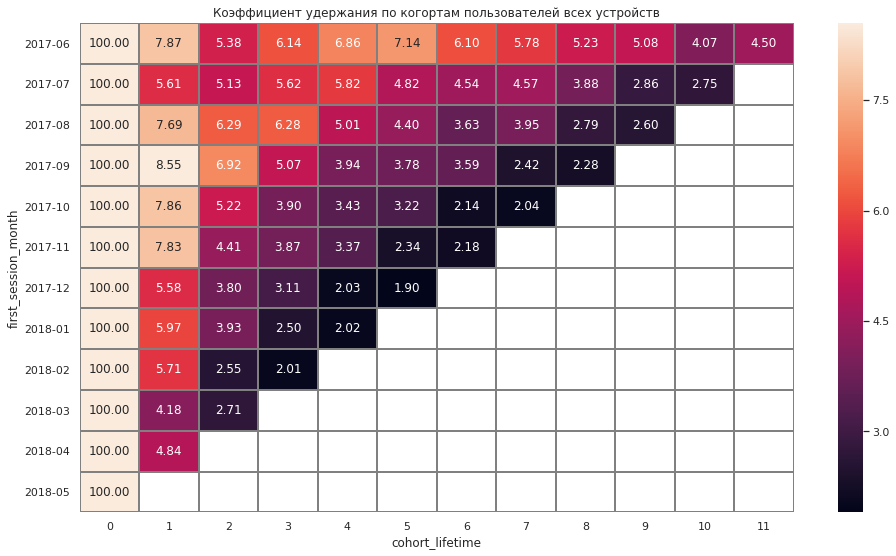

In [74]:
show_heatmap('Коэффициент удержания по когортам пользователей всех устройств', retention_per_cohort_pivot, rr_max)

#### 2.1.4.4. Изменение среднего коэффициента возврата по когортам

*Усредню значения коэффициентов возврата для всех когорт (кроме нулевой):*

In [75]:
#Все устройства:
mean_rr_var = retention_per_cohort_pivot.loc[:,1:].mean(axis=1).round(2).to_frame()
mean_rr_var.columns = ['all']
#Мобильные устройства:
mean_rr_var['touch'] = retention_per_cohort_pivot_touch.loc[:,1:].mean(axis=1).round(2)
#Стационарные устройства:
mean_rr_var['desktop'] = retention_per_cohort_pivot_desktop.loc[:,1:].mean(axis=1).round(2)
#mean_rr_var.reset_index(inplace=True)

*Нарисую диаграмму:*

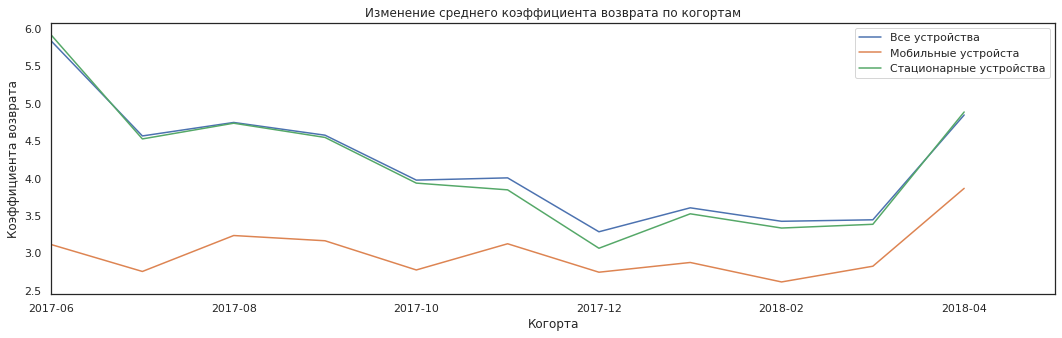

In [76]:
ax = mean_rr_var.plot(kind='line', figsize=(18,5))
ax.set_title('Изменение среднего коэффициента возврата по когортам')
ax.set_ylabel('Коэффициента возврата')
ax.set_xlabel('Когорта')
ax.legend(['Все устройства','Мобильные устройста','Стационарные устройства'])

*Как видно из графика, пользователи стационарных устройств все реже возвращаются на Ресурс. Показатели мобильной платформы практически не меняются. Хотя в конце периода наблюдения есть рост, его лучше не брать в расчет, т.к. он показывает только первый месяц существования последней когорты, который обычно успешнее последующих.
Для более глубоких выводов не хватает данных.*

**Вывод:**  
  *Хотя коэффициенты удержания малы для обеих платформ, можно все-таки увидеть различие между ними. К Ресурсу чаще возвращаются при использовании стационарных устройств. Но при этом коэффициент у мобильной платформы стабилен, а у стационарной постепенно снижается. Отсюда два предварительных заключения:*
   - *Сам Ресурс не располагает пользователей к возвращению*
   - *Наблюдается постепенное падение интереса к посещению Ресурса со стационарных устройств*

<a name="2.2.">-></a> 
<a href="#0">К содержанию</a>

## 2.2. Продажи

<a name="2.2.1.">-></a> 
<a href="#0">К содержанию</a>

### 2.2.1. Когда люди начинают покупать?

*Рассматривать буду только пользователей Яндекс.Афиша, которые оформили покупку. 
Cделаю разбивку на когорты, в качестве которых приму группы пользователей, впервые посетивших Яндекс.Афиша в один месяц. 
Для каждой когорты вместо средних значений посчитаю долю покупателей, совершивших покупку в первый день и первый час.*

*Найду даты первого визита для каждого посетителя Ресурса:*

<div class="alert alert-success">
<h2>Комментарий ревьюера</h2>

Инетерсный способ и подход к анализу времени до первой покупки. Молодец </div>

In [77]:
first_visits = visits.groupby('uid').agg({'start_dt':'min'})
first_visits.rename(columns={'start_dt':'first_start_dt'}, inplace=True)
first_visits.head()

,first_start_dt
uid,
11863502262781,2018-03-01 17:27:00
49537067089222,2018-02-06 15:55:00
297729379853735,2017-06-07 18:47:00
313578113262317,2017-09-18 22:49:00
325320750514679,2017-09-30 14:29:00


*Найду даты первой покупки для всех покупателей:*

In [78]:
first_orders = orders.groupby('uid').agg({'buy_dt':'min'})
first_orders.rename(columns={'buy_dt':'first_buy_dt'}, inplace=True)
first_orders.head()

,first_buy_dt
uid,
313578113262317,2018-01-03 21:51:00
1575281904278712,2017-06-03 10:13:00
2429014661409475,2017-10-11 18:33:00
2464366381792757,2018-01-28 15:54:00
2551852515556206,2017-11-24 10:14:00


*Объединю таблицы с первыми визитами и первыми заказами по пользователям:*

In [79]:
first_actions = first_visits.merge(first_orders,on='uid').reset_index()
first_actions.head()

,uid,first_start_dt,first_buy_dt
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


*Посчитаю разницу между датами первых посещений и покупок в днях и секундах:*

In [80]:
first_actions['interval_in_days'] = (
    (first_actions['first_buy_dt'] - first_actions['first_start_dt']).
    dt.days
)
first_actions['interval_in_seconds'] = (
    (first_actions['first_buy_dt'] - first_actions['first_start_dt']).
    dt.seconds
)
first_actions.head(3)

,uid,first_start_dt,first_buy_dt,interval_in_days,interval_in_seconds
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106,82920
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0,0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0,4740


*Добавлю номера когорт:*

In [81]:
first_actions['cohort'] = first_actions['first_start_dt'].astype('datetime64[M]').dt.strftime('%Y-%m')
first_actions.head(3)

,uid,first_start_dt,first_buy_dt,interval_in_days,interval_in_seconds,cohort
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106,82920,2017-09
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0,0,2017-06
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0,4740,2017-10


*Посчитаю число всех покупателей по когортам:*

In [82]:
all_buyers_by_cohorts = first_actions.groupby('cohort').agg({'uid':'count'})
all_buyers_by_cohorts.columns = ['total_orders']

*Посчитаю число покупателей "первого дня" по когортам:*

In [83]:
first_day_buyers_by_cohorts = first_actions.query('interval_in_days <=1').groupby('cohort').agg({'uid':'count'})
first_day_buyers_by_cohorts.columns = ['first_day_orders']

*Посчитаю число всех покупателей "первого часа" по когортам:*

In [84]:
first_hour_buyers_by_cohorts = first_actions.query('interval_in_seconds <=3600').groupby('cohort').agg({'uid':'count'})
first_hour_buyers_by_cohorts.columns = ['first_hour_orders']

*Построю тепловую карту:*

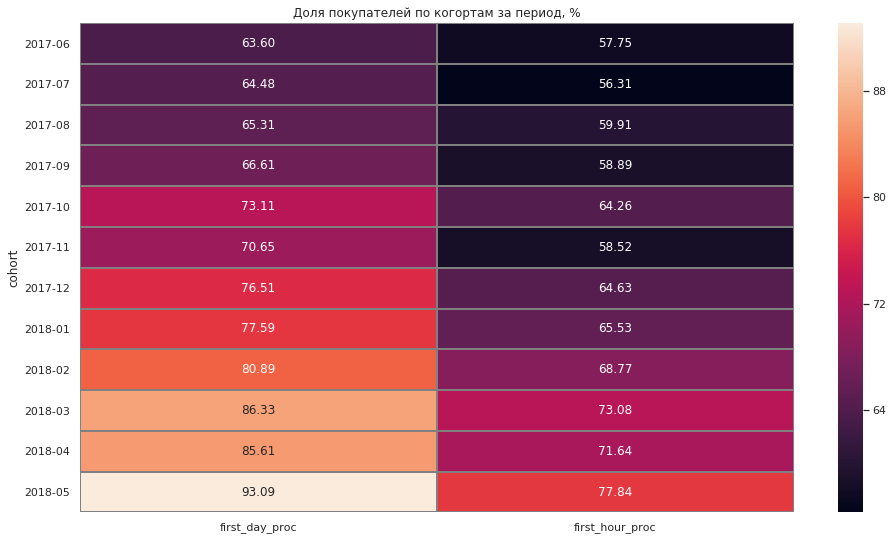

In [85]:
buyers_by_cohorts = all_buyers_by_cohorts.join(first_day_buyers_by_cohorts)
buyers_by_cohorts = buyers_by_cohorts.join(first_hour_buyers_by_cohorts)
buyers_by_cohorts['first_day_proc'] = (
    100 * round(buyers_by_cohorts['first_day_orders'] / buyers_by_cohorts['total_orders'], 4)
)
buyers_by_cohorts['first_hour_proc'] = (
    100 * round(buyers_by_cohorts['first_hour_orders'] / buyers_by_cohorts['total_orders'], 4)
)
buyers_by_cohorts_proc = buyers_by_cohorts[['first_day_proc', 'first_hour_proc']]
#Максимальна доля:
max_prop = buyers_by_cohorts_proc.max().max()
#Строю карту:
show_heatmap('Доля покупателей по когортам за период, %', buyers_by_cohorts_proc, max_prop)

**Выводы:**  
*Наблюдается стабильный рост покупателей, сделавших заказ в течение суток и часа с момента первого визита на Яндекс.Афиша.*

<a name="2.2.2.">-></a> 
<a href="#0">К содержанию</a>

### 2.2.2. Сколько раз покупают за период?

#### 2.2.2.1. Расчет по когортам

  - *Так же как и в предыдущем пункте, разделю данные по когортам, в качестве которых приму группы пользователей, впервые купивших на Яндекс.Афиша за один месяц.*  
  - *Посчитаю среднее количество покупок за день и неделю для каждой когорты. Но коэффициенты удержания получились очень низкими, поэтому расчет средних показателей за все время жизни когорт не имеет смысла - лучшие показатели будут, вероятнее, у самых молодых когорт.*   
  - *Т.к. львиная доля покупок происходит в первый месяц прихода нового клиента, то сравню показатели когорт именно для первых месяцев их существования.*

In [86]:
orders

,buy_dt,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50409,2018-05-31 23:43:00,3.67,1805512004303848280
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849


In [87]:
orders_w_periods = orders.copy(deep=True)

*Создам столбец с месяцем заказа и столбец со следующим месяцем:*

In [88]:
orders_w_periods['order_month'] = orders_w_periods['buy_dt'].astype('datetime64[M]')
orders_w_periods['next_order_month'] = (orders_w_periods['order_month'] + np.timedelta64(31,'D')).astype('datetime64[M]')

*Получилась таблица:*

In [89]:
orders_w_periods.head(3)

,buy_dt,revenue,uid,order_month,next_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-07-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-07-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-07-01


*Воспользуюсь созданной ранее таблицей с датами первых заказов и создам столбец с названиями когорт.*

In [90]:
orders_w_periods = orders_w_periods.merge(first_orders, on='uid').reset_index()
orders_w_periods.rename(columns={'first_buy_dt':'cohort'}, inplace=True)
orders_w_periods['cohort'] = orders_w_periods['cohort'].astype('datetime64[M]')
orders_w_periods.head(3)

,index,buy_dt,revenue,uid,order_month,next_order_month,cohort
0,0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-07-01,2017-06-01
1,1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-07-01,2017-06-01
2,2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-07-01,2017-06-01


*Оставлю только строки с покупками, совершенными в месяц создания соответствующей когорты:*

In [91]:
orders_w_periods = orders_w_periods[(orders_w_periods['cohort'] >= orders_w_periods['order_month']) &
                 (orders_w_periods['cohort'] < orders_w_periods['next_order_month'])
                ]
orders_w_periods.head(3)

,index,buy_dt,revenue,uid,order_month,next_order_month,cohort
0,0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-07-01,2017-06-01
1,1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-07-01,2017-06-01
2,2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-07-01,2017-06-01


*Сгруппирую данные по когортам и посчитаю количество заказов:*

In [92]:
orders_by_cohorts = orders_w_periods.groupby('cohort').agg({'uid':'count'}).reset_index()
orders_by_cohorts.rename(columns={'uid':'orders_number'}, inplace=True)
orders_by_cohorts 

,cohort,orders_number
0,2017-06-01,2354
1,2017-07-01,2186
2,2017-08-01,1533
3,2017-09-01,2933
4,2017-10-01,4964
5,2017-11-01,4813
6,2017-12-01,5052
7,2018-01-01,3783
8,2018-02-01,4095
9,2018-03-01,4130


*Добавлю столбцы со средними значениями продаж в день и неделю и оптимизирую данные в таблицах:*

In [93]:
orders_by_cohorts['orders_in_day'] = round(orders_by_cohorts['orders_number'] * 12 / 365, 2)
orders_by_cohorts['orders_in_week'] = round(orders_by_cohorts['orders_number'] * 12 * 7 / 365, 2)
orders_by_cohorts['cohort'] = orders_by_cohorts['cohort'].dt.strftime('%Y-%m')
orders_by_cohorts.index = orders_by_cohorts['cohort']
mean_orders_by_cohorts = orders_by_cohorts[['orders_in_day','orders_in_week']]
mean_orders_by_cohorts 

,orders_in_day,orders_in_week
cohort,,
2017-06,77.39,541.74
2017-07,71.87,503.08
2017-08,50.40,352.80
2017-09,96.43,674.99
2017-10,163.20,1142.40
2017-11,158.24,1107.65
2017-12,166.09,1162.65
2018-01,124.37,870.61
2018-02,134.63,942.41


*Нарисую диаграмму:*

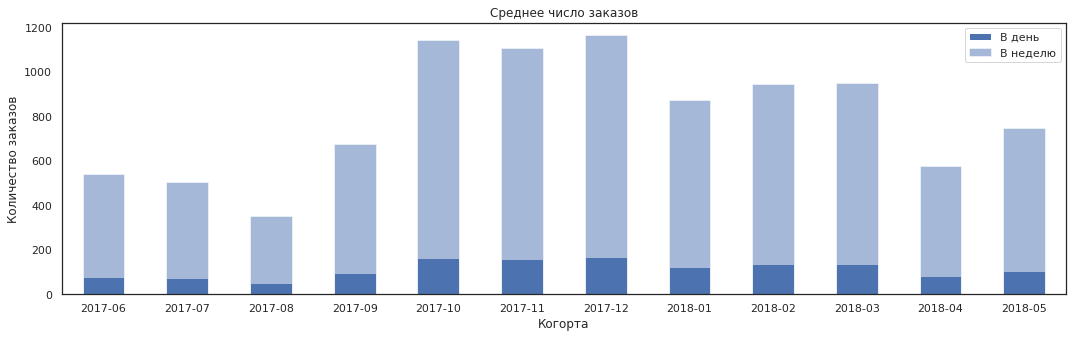

In [94]:
ax = mean_orders_by_cohorts.plot(kind='bar', y='orders_in_day', figsize=(18,5), rot=0)
mean_orders_by_cohorts.plot(kind='bar', y='orders_in_week', figsize=(18,5), rot=0, alpha=0.5, ax=ax)
ax.set_title('Среднее число заказов')
ax.set_ylabel('Количество заказов')
ax.set_xlabel('Когорта')
ax.legend(['В день', 'В неделю'])

#### 2.2.2.2. Расчет по месяцам

*Добавлю в таблицу с заказами столбец с месяцем:*

In [95]:
orders['order_month'] = orders['buy_dt'].astype('datetime64[M]')

*Посчитаю количество заказов по месяцам и построю диаграмму:*

In [96]:
orders_by_months = orders.groupby('order_month').agg({'buy_dt':'count'})

Text(0.5, 0, 'Месяц')

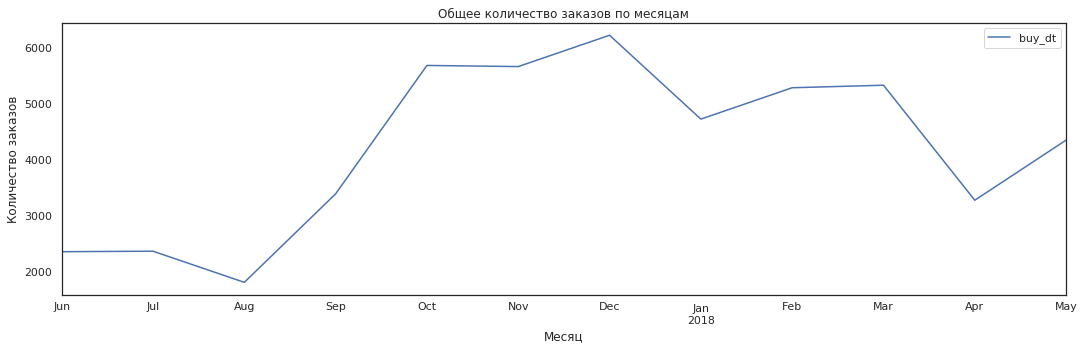

In [97]:
ax = orders_by_months.plot(kind='line', figsize=(18,5))
ax.set_title('Общее количество заказов по месяцам')
ax.set_ylabel('Количество заказов')
ax.set_xlabel('Месяц')

**Вывод:** *В холодные месяцы продажи билетов возрастают.*

<a name="2.2.3.">-></a> 
<a href="#0">К содержанию</a>

### 2.2.3. Какой средний чек?

*Для решения данной задачи воспользуюсь анализом по когортам. В качестве когорты приму группу покупателей, совершивших первую покупку в один месяц. Объединю таблицу **orders** с ранее созданной таблицей **first_orders** по пользователям:*

In [98]:
orders = orders.merge(first_orders, on='uid')

*Изменю название столбца с датой первой покупки и заменю его содержимое с полной даты на месяц:*

In [99]:
orders.rename(columns={'first_buy_dt':'first_order_month'}, inplace=True)
orders['first_order_month'] = orders['first_order_month'].astype('datetime64[M]')

*Сгруппирую данные по когортам:*

In [100]:
orders_grouped_by_cohorts = (
    orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum','uid':'count'})
).reset_index()
orders_grouped_by_cohorts.rename(columns={'uid':'orders_number'}, inplace=True)
orders_grouped_by_cohorts.sample(3)

,first_order_month,order_month,revenue,orders_number
36,2017-09-01,2017-12-01,10261.52,164
7,2017-06-01,2018-01-01,1176.56,174
72,2018-03-01,2018-03-01,17095.49,4130


*Добавлю столбец со средним чеком:*

In [101]:
orders_grouped_by_cohorts['revenue_per_order'] = round(
    orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['orders_number'], 2)
orders_grouped_by_cohorts.sample(3)

,first_order_month,order_month,revenue,orders_number,revenue_per_order
9,2017-06-01,2018-03-01,1225.51,153,8.01
23,2017-08-01,2017-08-01,7228.83,1533,4.72
55,2017-11-01,2018-04-01,219.88,59,3.73


*Добавлю столбец с параметром lifetime для когорт:*

In [102]:
#Вычисляю разницу в днях между меяцем заказа и первым месяцем заказа:
orders_grouped_by_cohorts['cohort_lifetime'] = (
    orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month']
)
#Меняю разницу в днях на порядковый месяц lifetime:
orders_grouped_by_cohorts['cohort_lifetime'] = round(
    orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
).astype('int')
orders_grouped_by_cohorts.sample(3)

,first_order_month,order_month,revenue,orders_number,revenue_per_order,cohort_lifetime
76,2018-04-01,2018-05-01,1209.92,195,6.20,1
74,2018-03-01,2018-05-01,1114.87,176,6.33,2
66,2018-01-01,2018-04-01,481.59,64,7.52,3


*Заменю даты первой покупки на данные в формате "год-месяц":*

In [103]:
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m') 

*Сводная таблица с данными о среднем чеке по когортам и lifetime:*

In [104]:
revenue_per_cohort_pivot = (
    orders_grouped_by_cohorts.pivot_table(index='first_order_month', columns='cohort_lifetime', values='revenue_per_order')
)
revenue_per_cohort_pivot.sample(3)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-07,5.29,6.45,9.99,6.64,4.72,3.66,3.79,5.45,5.35,11.79,5.65,NaN
2017-09,4.97,13.17,8.35,62.57,15.43,15.32,16.77,11.21,7.79,NaN,NaN,NaN
2018-01,3.69,4.44,6.45,7.52,2.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN


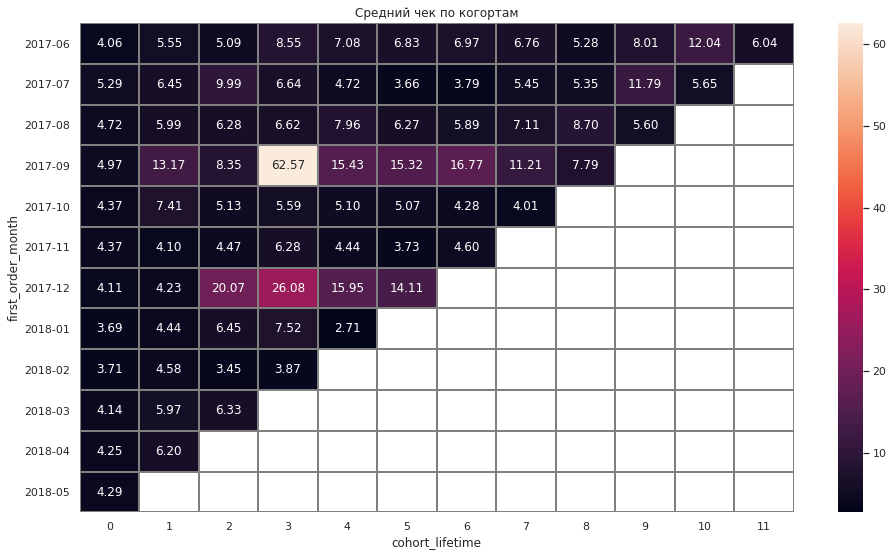

In [105]:
average_check_max = revenue_per_cohort_pivot.max().max()
show_heatmap('Средний чек по когортам', revenue_per_cohort_pivot, average_check_max)

**Вывод:** *Запрашиваемые данные отображены на тепловой карте выше. Самые большие средние чеки у когорт: 2017-09, 2017-12 и 2017-06. Есть аномальное значение у когорты 2017-09 при покупках в декабре того же года. У когорты именно этого декабря тоже пик черз такой же промежуток времени(4 месяца). Возможно, покупатели их этих 2-х когорт получили в свои нулевые месяцы купоны и их срок подходил к концу?)*

<a name="2.2.4.">-></a> 
<a href="#0">К содержанию</a>

### 2.2.4. Сколько денег приносят? (LTV)

*Для решения данной задачи также воспользуюсь анализом по когортам. В качестве когорты приму группу покупателей, совершивших первую покупку в один месяц. Использую обновленную в прошлом пункте таблицу **orders**.*

In [106]:
orders.sample(3)

,buy_dt,revenue,uid,order_month,first_order_month
39746,2018-02-27 14:39:00,3.67,2634683502065850235,2018-02-01,2018-02-01
34778,2018-01-28 12:37:00,3.97,14323998122436559765,2018-01-01,2018-01-01
32450,2018-01-10 13:36:00,0.18,13210681786444126168,2018-01-01,2018-01-01


*Посчитаю численность когорт:*

In [107]:
cohort_sizes = orders.groupby('first_order_month').agg({'uid':'nunique'})
cohort_sizes.rename(columns={'uid':'cohort_size'}, inplace=True)
cohort_sizes.sample(3)

,cohort_size
first_order_month,
2018-04-01,2276
2017-11-01,4081
2018-03-01,3533


*Объявлю новую таблицу с названиями когорт(first_order_month) и их численностью:*

In [108]:
orders_by_cohorts = orders[['first_order_month','order_month','revenue']].merge(cohort_sizes, on='first_order_month')
orders_by_cohorts.reset_index()
orders_by_cohorts.sample(3)

,first_order_month,order_month,revenue,cohort_size
6598,2017-07-01,2018-01-01,1.22,1923
23444,2017-11-01,2017-11-01,7.94,4081
17154,2017-10-01,2017-10-01,2.20,4340


*Посчитаю суммарный доход по группам(first_order_month/order_month):*

In [109]:
revenue_by_cohorts = (
    orders_by_cohorts.groupby(['first_order_month','order_month','cohort_size'])
    .agg({'revenue':'sum'})
    .reset_index()
)
revenue_by_cohorts.head(3)

,first_order_month,order_month,cohort_size,revenue
0,2017-06-01,2017-06-01,2023,9557.49
1,2017-06-01,2017-07-01,2023,981.82
2,2017-06-01,2017-08-01,2023,885.34


*Т.к. Ресурс ничего не производит и не занимается перепродажей, то приму маржинальность = 100%.   
Добавлю новый столбец с LTV:*

In [110]:
revenue_by_cohorts['ltv'] = round(revenue_by_cohorts['revenue'] / revenue_by_cohorts['cohort_size'], 2)
revenue_by_cohorts.head(3)

,first_order_month,order_month,cohort_size,revenue,ltv
0,2017-06-01,2017-06-01,2023,9557.49,4.72
1,2017-06-01,2017-07-01,2023,981.82,0.49
2,2017-06-01,2017-08-01,2023,885.34,0.44


In [111]:
revenue_by_cohorts['order_month'] = (
    (revenue_by_cohorts['order_month'] - revenue_by_cohorts['first_order_month']) / np.timedelta64(1,'M')
).round().astype('int')
revenue_by_cohorts.rename(columns={'order_month':'cohort_lifetime'}, inplace=True)
revenue_by_cohorts.head(3)

,first_order_month,cohort_lifetime,cohort_size,revenue,ltv
0,2017-06-01,0,2023,9557.49,4.72
1,2017-06-01,1,2023,981.82,0.49
2,2017-06-01,2,2023,885.34,0.44


*Заменю месяцы заказов на номера lifetime и изменю названия когорт.*

In [112]:
revenue_by_cohorts['first_order_month'] = revenue_by_cohorts['first_order_month'].dt.strftime('%Y-%m')

*Сводная таблица с данными об LTV по когортам и lifetime:*

In [113]:
ltv_per_cohort_pivot = revenue_by_cohorts.pivot_table(
    index = 'first_order_month', 
    columns = 'cohort_lifetime',
    values = 'ltv')
ltv_per_cohort_pivot.head(3)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,NaN
2017-08,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,NaN,NaN


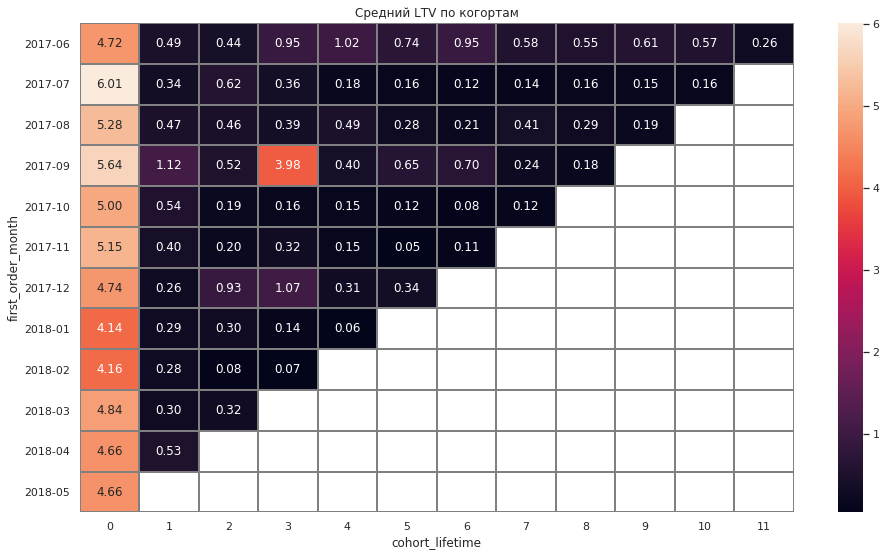

In [114]:
max_ltv = ltv_per_cohort_pivot.max().max()
show_heatmap('Средний LTV по когортам', ltv_per_cohort_pivot, max_ltv)

*Также отображу тепловую карту по накопительному LTV:*

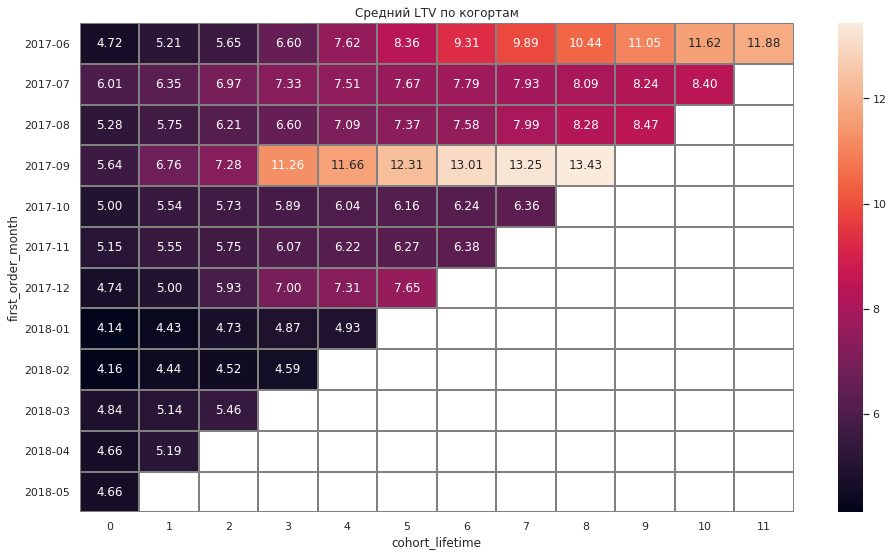

In [115]:
ltv_per_cohort_pivot_acc = ltv_per_cohort_pivot.cumsum(axis=1)
max_ltv_acc = ltv_per_cohort_pivot_acc.max().max()
show_heatmap('Средний LTV по когортам', ltv_per_cohort_pivot_acc, max_ltv_acc)

*У разных когорт разная скорость роста. Cравню средние скорости роста каждой когорты (сумма разниц накопительного LTV между соседними месяцами, деленная на время жизни когорты). Объявлю функцию для подстчета средней скорости роста:*

In [116]:
def get_mean_growth(row):
    #Общее время жизни когорты:
    total_lifetime = row.notnull().sum()
    #Список значений когорты:
    row_values = row.values
    ltv_diff_sum = 0
    for index in range(0, total_lifetime-1):
        #Разница значений LTV соседних lifetime:
        ltv_diff = row_values[index+1] - row_values[index]
        ltv_diff_sum += ltv_diff
    #Средняя скорость:
    if total_lifetime > 1:
        mean_growth = round(ltv_diff_sum / (total_lifetime-1), 3)
    else:
        mean_growth = 0
    return mean_growth

*Добавлю столбец со скоростями и изображу их на диаграмме:*

In [117]:
ltv_per_cohort_pivot_acc['mean_growth'] = ltv_per_cohort_pivot_acc.apply(get_mean_growth, axis=1)

Text(0.5, 0, 'Когорта')

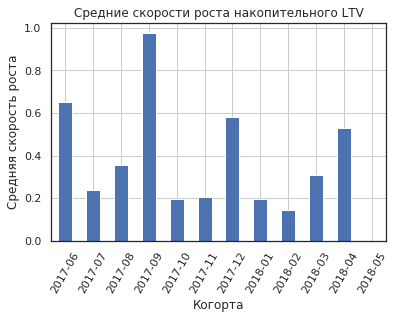

In [118]:
ax = ltv_per_cohort_pivot_acc.plot(kind='bar', y='mean_growth', rot=60, grid=True, legend=False)
ax.set_title('Средние скорости роста накопительного LTV')
ax.set_ylabel('Средняя скорость роста')
ax.set_xlabel('Когорта')

**Вывод**: *Самая выгодная когорта - от сентября 2019 года. Для более глубокого анализа не достаточно данных (после мая 2018 данные заканчиваются)*

<a name="2.3.">-></a> 
<a href="#0">К содержанию</a>

## 2.3. Маркетинг

<a name="2.3.1.">-></a> 
<a href="#0">К содержанию</a>

### 2.3.1. 	Сколько денег потратили? Всего / на каждый источник / по времени

*Найду, сколько раз пришли с рекламных источников:*

#### 2.3.1.1. Общие затраты

In [119]:
costs['costs'].sum()

329131.62

#### 2.3.1.2. Затраты на каждый источник

In [120]:
costs_by_sources = costs.groupby('source_id').agg({'costs':'sum'})

Text(0.5, 0, 'Рекламный источник')

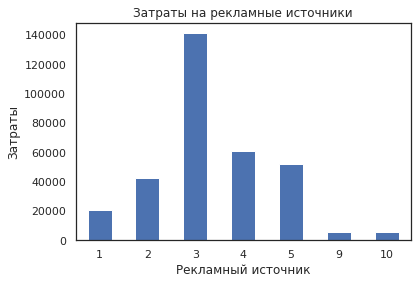

In [121]:
ax = costs_by_sources.plot(kind='bar', rot=0, legend=False)
ax.set_title('Затраты на рекламные источники')
ax.set_ylabel('Затраты')
ax.set_xlabel('Рекламный источник')

#### 2.3.1.3. Затраты на каждый источник по месяцам

*Добавлю столбец с месяцем:*

In [122]:
costs['month'] = costs['dt'].astype('datetime64[M]')

*Сгруппирую по источникам и месяцам:*

In [123]:
costs_by_sources_and_months = costs.pivot_table(
    index = 'source_id',
    columns = 'month',
    values = 'costs',
    aggfunc='sum')
costs_by_sources_and_months

month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,1125.61,1072.88,951.81,1502.01,2315.75,2445.16,2341.20,2186.18,2204.48,1893.09,1327.49,1467.61
2,2427.38,2333.11,1811.05,2985.66,4845.00,5247.68,4897.80,4157.74,4474.34,3943.14,2993.70,2689.44
3,7731.65,7674.37,6143.54,9963.55,15737.24,17025.34,16219.52,14808.78,14228.56,13080.85,9296.81,9411.42
4,3514.80,3529.73,3217.36,5192.26,6420.84,5388.82,7680.47,5832.79,5711.96,5961.87,4408.49,4214.21
5,2616.12,2998.14,2185.28,3849.14,5767.40,6325.34,5872.52,5371.52,5071.31,4529.62,3501.15,3669.56
9,285.22,302.54,248.93,415.62,609.41,683.18,657.98,547.16,551.50,480.29,373.49,362.17
10,314.22,329.82,232.57,460.67,627.24,792.36,645.86,614.35,480.88,526.41,388.25,409.86


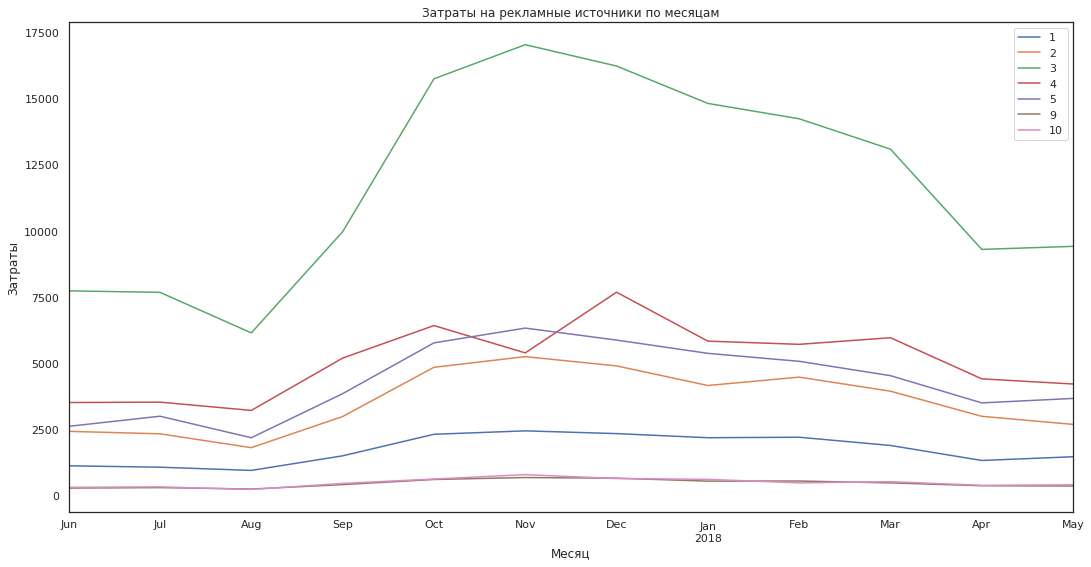

In [124]:
ax = costs_by_sources_and_months.loc[1].plot(kind='line', figsize=(18,6))
for source in costs_by_sources_and_months.index:
    if source != 1:
        costs_by_sources_and_months.loc[source].plot(kind='line', figsize=(18,9), ax=ax)
ax.set_title('Затраты на рекламные источники по месяцам')
ax.set_ylabel('Затраты')
ax.set_xlabel('Месяц')
ax.legend(costs_by_sources_and_months.index)

**Выводы**:
 - *Больше всего переходят с рекламного источника номер 3*
 - *Холодные месяцы - самые активные*

<a name="2.3.2.">-></a> 
<a href="#0">К содержанию</a>

### 2.3.2. Сколько стоило привлечение одного покупателя из каждого источника?

*Объединю таблицы со всеми визитами и первыми заказами:*

In [125]:
#Обновлю таблицу с первыми заказами (столбец revenue понадобится в следующем пункте):
first_orders = orders.groupby('uid').agg({'buy_dt':'min', 'revenue':'sum'}).reset_index()
first_orders.rename(columns={'buy_dt':'first_buy_dt'}, inplace=True)
#Объединяю таблицы:
visits_and_first_orders = first_orders.merge(visits[['uid','start_dt','end_dt','source_id']], on='uid')
visits_and_first_orders

,uid,first_buy_dt,revenue,start_dt,end_dt,source_id
0,313578113262317,2018-01-03 21:51:00,0.55,2018-03-11 17:23:00,2018-03-11 17:29:00,2
1,313578113262317,2018-01-03 21:51:00,0.55,2017-09-18 22:49:00,2017-09-18 23:07:00,2
2,313578113262317,2018-01-03 21:51:00,0.55,2018-02-18 15:17:00,2018-02-18 15:26:00,2
3,1575281904278712,2017-06-03 10:13:00,3.05,2017-06-03 10:13:00,2017-06-03 10:17:00,10
4,1575281904278712,2017-06-03 10:13:00,3.05,2017-06-03 17:36:00,2017-06-03 17:48:00,10
...,...,...,...,...,...,...
97388,18446156210226471712,2018-02-18 19:34:00,9.78,2018-02-14 21:05:00,2018-02-14 21:47:00,5
97389,18446156210226471712,2018-02-18 19:34:00,9.78,2018-02-24 09:36:00,2018-02-24 09:37:00,4
97390,18446156210226471712,2018-02-18 19:34:00,9.78,2018-02-19 10:17:00,2018-02-19 11:26:00,1
97391,18446167067214817906,2017-10-17 10:16:00,7.94,2017-10-17 10:05:00,2017-10-17 10:07:00,5


*Данные о заказах, которые отображены в таблице с визитами:*

In [126]:
orders_after_jump_from_source = visits_and_first_orders[
    (visits_and_first_orders['first_buy_dt'] >= visits_and_first_orders['start_dt']) &
    (visits_and_first_orders['first_buy_dt'] <= visits_and_first_orders['end_dt'])
]
orders_after_jump_from_source

,uid,first_buy_dt,revenue,start_dt,end_dt,source_id
3,1575281904278712,2017-06-03 10:13:00,3.05,2017-06-03 10:13:00,2017-06-03 10:17:00,10
9,2551852515556206,2017-11-24 10:14:00,10.99,2017-11-24 10:14:00,2017-11-24 10:14:19,5
10,3077748354309989,2018-03-03 12:33:00,4.67,2018-03-03 12:08:00,2018-03-03 12:38:00,3
25,3605148382144603,2017-09-21 20:56:00,0.69,2017-09-21 20:52:00,2017-09-21 21:22:00,2
27,4808417689019433,2018-01-09 23:32:00,1.22,2018-01-09 23:10:00,2018-01-09 23:33:00,4
...,...,...,...,...,...,...
97374,18442106212931715033,2018-01-06 00:35:00,2.81,2018-01-05 23:37:00,2018-01-06 01:01:00,4
97376,18442290965339407211,2018-02-05 19:39:00,0.18,2018-02-05 19:35:00,2018-02-05 19:58:00,3
97378,18445407535914413204,2017-09-22 23:55:00,0.88,2017-09-22 23:48:00,2017-09-22 23:55:00,3
97381,18445601152732270159,2018-03-26 22:54:00,4.22,2018-03-26 21:04:00,2018-03-26 23:32:00,2


*Т.е. получается, что в таблице с визитами нет данных о стольки сессиях с первой покупкой:*

In [127]:
first_orders.shape[0] - orders_after_jump_from_source.shape[0]

7629

*Создам таблицу для учета таких заказов:*

In [128]:
#Список всех покупателей:
first_orders_uids = first_orders['uid'].to_list()
#Список покупателей, совершивших заказ после перехода с рекламного источника:
orders_after_jump_uids = orders_after_jump_from_source['uid'].to_list()
#Список покупателей, совершивших заказ без перехода с рекламного источника:
orders_wo_jump_uids = list(set(first_orders_uids) - set(orders_after_jump_uids))
#Таблица с первыми заказами тех, кто купил без перехода с рекламного источника:
orders_wo_jump_from_source = first_orders.query('uid in @orders_wo_jump_uids')
#Обновлю таблицу с первыми визитами:
first_visits = visits.groupby('uid').agg({'start_dt':'min', 'source_id':'first'}).reset_index()
#Объединю таблицы с первыми визитами и первыми заказами для тех, кто купил не после перехода из источника:
orders_wo_jump_from_source = orders_wo_jump_from_source.merge(first_visits, on='uid')
orders_wo_jump_from_source

,uid,first_buy_dt,revenue,start_dt,source_id
0,313578113262317,2018-01-03 21:51:00,0.55,2017-09-18 22:49:00,2
1,2429014661409475,2017-10-11 18:33:00,73.33,2017-10-11 17:14:00,3
2,2464366381792757,2018-01-28 15:54:00,2.44,2018-01-27 20:10:00,5
3,3753586865891862,2018-03-03 13:50:00,3.50,2018-03-03 13:47:00,4
4,6339315367323360,2018-02-17 14:49:00,1.04,2018-02-17 14:40:00,2
...,...,...,...,...,...
7624,18436650472890569350,2017-06-07 12:34:00,0.37,2017-06-06 16:08:00,4
7625,18436668870808047386,2018-02-04 09:36:00,2.20,2017-11-16 14:46:00,3
7626,18440933819332658804,2018-01-28 11:22:00,0.98,2017-10-05 23:03:00,3
7627,18445147675727495770,2017-11-24 09:03:00,3.05,2017-08-20 13:30:00,5


*Добавлю в обе таблицы столбцы с расчетным месяцем:*

In [129]:
orders_after_jump_from_source['calc_month'] = (
    orders_after_jump_from_source['first_buy_dt'].astype('datetime64[M]')
)
orders_wo_jump_from_source['calc_month'] = (
    orders_wo_jump_from_source['start_dt'].astype('datetime64[M]')
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


*Сводные таблицы по источникам и месяцам с количеством уникальных покупателей:*

In [130]:
buyers_after_jump_from_source_pivot = orders_after_jump_from_source.pivot_table(
    index = 'source_id',
    columns = 'calc_month',
    values = 'uid',
    aggfunc = 'count'
)
buyers_wo_jump_from_source_pivot = orders_wo_jump_from_source.pivot_table(
    index = 'source_id',
    columns = 'calc_month',
    values = 'uid',
    aggfunc = 'count'
)

*Суммарная таблица:*

In [131]:
buyers_by_sources_and_months = buyers_after_jump_from_source_pivot + buyers_wo_jump_from_source_pivot
buyers_by_sources_and_months

calc_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,293.0,274.0,170.0,336.0,499.0,534.0,545.0,387.0,390.0,378.0,255.0,323.0
2,345.0,275.0,157.0,310.0,487.0,482.0,430.0,310.0,335.0,334.0,219.0,402.0
3,675.0,500.0,339.0,713.0,1052.0,1044.0,1081.0,839.0,885.0,746.0,454.0,636.0
4,497.0,553.0,360.0,612.0,1156.0,1147.0,1259.0,953.0,952.0,907.0,586.0,638.0
5,462.0,458.0,383.0,657.0,1022.0,683.0,753.0,649.0,686.0,516.0,425.0,521.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,104.0,64.0,74.0,93.0,129.0,136.0,93.0,69.0,60.0,115.0,17.0,36.0
10,101.0,53.0,45.0,79.0,201.0,124.0,74.0,91.0,122.0,160.0,105.0,107.0


*В общую таблицу проникла строка седьмого источника с пустыми элементами. Удалю ее:*

In [132]:
buyers_by_sources_and_months.dropna(inplace=True)

*Окончательная таблица со CAC по источникам и месяцам:*

In [133]:
cac_by_sources_and_months = costs_by_sources_and_months / buyers_by_sources_and_months
cac_by_sources_and_months

month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,3.841672,3.915620,5.598882,4.470268,4.640782,4.578951,4.295780,5.649044,5.652513,5.008175,5.205843,4.543684
2,7.035884,8.484036,11.535350,9.631161,9.948665,10.887303,11.390233,13.412065,13.356239,11.805808,13.669863,6.690149
3,11.454296,15.348740,18.122537,13.974123,14.959354,16.307797,15.004181,17.650513,16.077469,17.534651,20.477555,14.797830
4,7.072032,6.382875,8.937111,8.484085,5.554360,4.698187,6.100453,6.120451,5.999958,6.573175,7.523020,6.605345
5,5.662597,6.546157,5.705692,5.858661,5.643249,9.261113,7.798831,8.276610,7.392580,8.778333,8.238000,7.043301
9,2.742500,4.727187,3.363919,4.469032,4.724109,5.023382,7.075054,7.929855,9.191667,4.176435,21.970000,10.060278
10,3.111089,6.223019,5.168222,5.831266,3.120597,6.390000,8.727838,6.751099,3.941639,3.290063,3.697619,3.830467


*Построю график:*

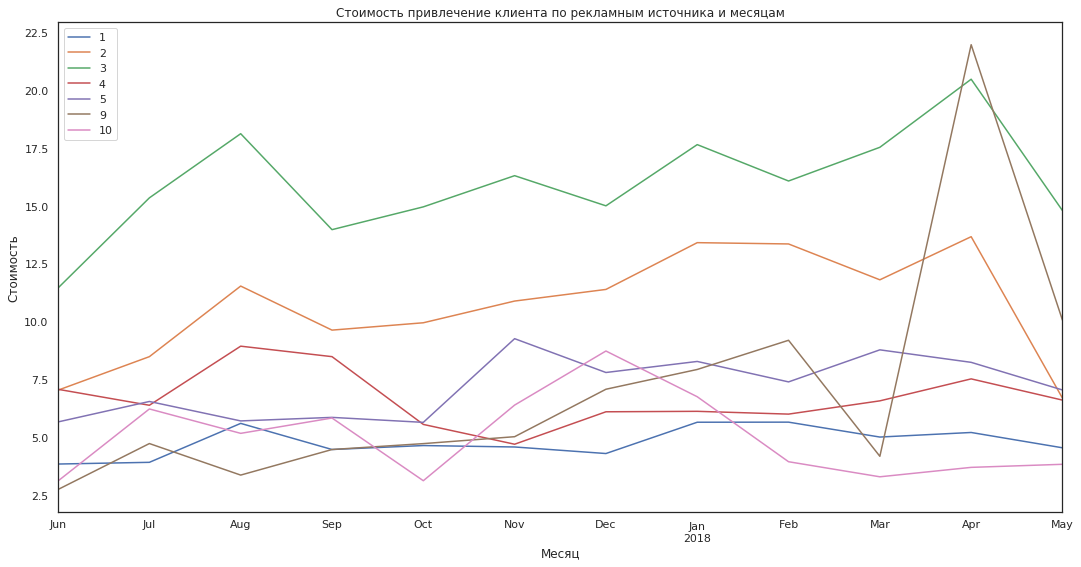

In [134]:
ax = cac_by_sources_and_months.loc[1].plot(kind='line', figsize=(18,6))
for source in cac_by_sources_and_months.index:
    if source != 1:
        cac_by_sources_and_months.loc[source].plot(kind='line', figsize=(18,9), ax=ax)
ax.set_title('Стоимость привлечение клиента по рекламным источника и месяцам')
ax.set_ylabel('Стоимость')
ax.set_xlabel('Месяц')
ax.legend(cac_by_sources_and_months.index)

**Выводы**:
 - *Самые большие затраты на привлечение из источника 3*
 - *У источника 9 есть аномально высокое значение в апреле 2018-го*

<a name="2.3.3.">-></a> 
<a href="#0">К содержанию</a>

### 2.3.3. Насколько окупились расходы? (ROI)

*В качестве ROI приму ROMI, рассчитываемый по упрощенной схеме: "Прибыль" / "Затраты на маркетинг". Посчитаю ROI по источникам рекламы и месяцам. Затраты уже известны из этой таблицы:*

In [135]:
costs_by_sources_and_months

month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,1125.61,1072.88,951.81,1502.01,2315.75,2445.16,2341.20,2186.18,2204.48,1893.09,1327.49,1467.61
2,2427.38,2333.11,1811.05,2985.66,4845.00,5247.68,4897.80,4157.74,4474.34,3943.14,2993.70,2689.44
3,7731.65,7674.37,6143.54,9963.55,15737.24,17025.34,16219.52,14808.78,14228.56,13080.85,9296.81,9411.42
4,3514.80,3529.73,3217.36,5192.26,6420.84,5388.82,7680.47,5832.79,5711.96,5961.87,4408.49,4214.21
5,2616.12,2998.14,2185.28,3849.14,5767.40,6325.34,5872.52,5371.52,5071.31,4529.62,3501.15,3669.56
9,285.22,302.54,248.93,415.62,609.41,683.18,657.98,547.16,551.50,480.29,373.49,362.17
10,314.22,329.82,232.57,460.67,627.24,792.36,645.86,614.35,480.88,526.41,388.25,409.86


*Отображу доходы аналогичным образом. В предыдущем пункте выполена часть необходимых вычислений. Использую  таблицы **orders_after_jump_from_source** и **orders_wo_jump_from_source** и иначе их сгруппирую:*

In [136]:
revenue_after_jump_from_source_pivot = orders_after_jump_from_source.pivot_table(
    index = 'source_id',
    columns = 'calc_month',
    values = 'revenue',
    aggfunc = 'sum'
)
revenue_wo_jump_from_source_pivot = orders_wo_jump_from_source.pivot_table(
    index = 'source_id',
    columns = 'calc_month',
    values = 'revenue',
    aggfunc = 'sum'
)

*Суммарная таблица:*

In [137]:
revenue_by_sources_and_months = revenue_after_jump_from_source_pivot + revenue_wo_jump_from_source_pivot
revenue_by_sources_and_months

calc_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,12471.01,2608.64,2490.56,3025.70,4337.90,3705.55,3187.46,2886.98,2011.60,2000.86,2000.48,1699.30
2,7386.96,3027.26,1118.30,4524.70,5167.07,3934.78,13521.64,2510.74,2090.03,3037.73,1427.18,3144.22
3,4088.34,2943.71,2113.15,4722.00,5490.04,5412.76,5073.55,3534.27,3582.19,3050.83,2121.00,2294.97
4,3985.24,4254.22,2720.65,4666.98,6278.60,6104.77,5775.73,3884.47,4609.75,4370.74,2886.62,2583.80
5,3984.30,2992.09,3811.62,15653.07,5993.83,3517.99,4102.10,2905.51,3079.47,2445.54,2019.92,2159.15
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,511.85,980.36,406.27,864.80,594.84,542.53,423.78,217.25,343.90,293.18,97.51,143.17
10,254.59,182.52,280.31,187.83,567.59,540.74,269.22,300.49,314.49,550.47,268.76,386.49


*В общую таблицу проникла строка седьмого источника с пустыми элементами. Удалю ее:*

In [138]:
revenue_by_sources_and_months.dropna(inplace=True)

*Теперь посчитаю окупаемость. это будет накопительный ROI в течение наблюдаемого времени:*

In [139]:
roi_by_sources_and_months = 100 * revenue_by_sources_and_months.cumsum(axis=1) / costs_by_sources_and_months.cumsum(axis=1)
roi_by_sources_and_months

calc_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,1107.933476,685.909420,557.731327,442.702872,357.830013,304.246156,270.764700,249.012238,227.471155,214.690625,210.303909,203.645611
2,304.318236,218.763615,175.491894,168.011761,147.368388,128.036762,157.573791,143.497117,130.445428,124.772607,119.019035,118.886517
3,52.877976,45.644819,42.437989,44.004543,40.967400,38.537120,37.074939,35.022479,33.743403,32.631703,31.939787,31.436667
4,113.384545,116.962523,106.804010,101.119052,100.140343,102.738612,96.685895,92.381969,90.947069,88.942516,87.123288,85.342226
5,152.298060,124.261969,138.315978,226.987779,186.235422,151.435340,135.257247,122.795327,114.936826,108.745113,105.028122,101.753363
9,179.457962,253.880836,226.903632,220.654630,180.377286,153.273213,135.016922,121.110175,113.577463,108.300797,102.346120,98.222924
10,81.022850,67.870008,81.840271,67.693378,74.972003,73.038362,67.087112,64.307496,64.424174,68.630358,68.672900,70.476720


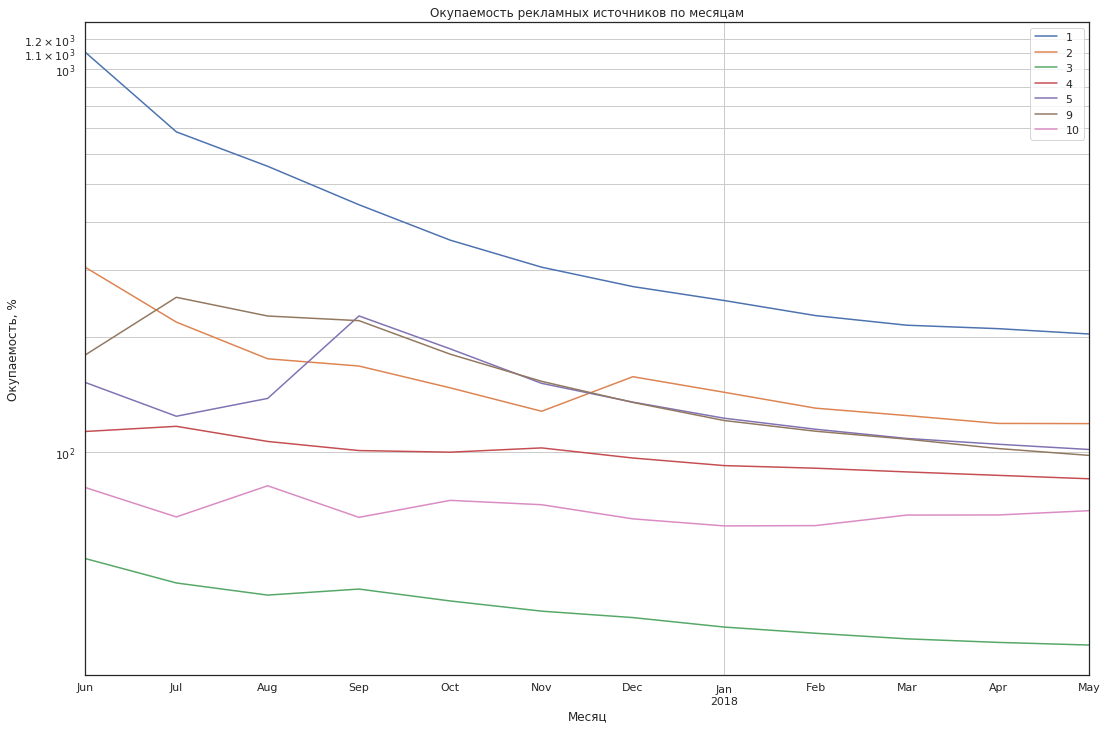

In [140]:
#Задам лимит по Оси Ординат:
y_limit = 100 * math.ceil(1.1 * roi_by_sources_and_months.max().max()/100)
#Нарисую графики:
ax = roi_by_sources_and_months.loc[1].plot(kind='line', figsize=(18,12),  grid=True, logy=True, yticks=range(0,y_limit,100))
for source in roi_by_sources_and_months.index:
    if source != 1:
        roi_by_sources_and_months.loc[source].plot(kind='line', ax=ax,  grid=True)
ax.set_title('Окупаемость рекламных источников по месяцам')
ax.set_ylabel('Окупаемость, %')
ax.set_xlabel('Месяц')
ax.legend(cac_by_sources_and_months.index)

**Выводы:** 
 - *Отлично окупается источник 1*
 - *Хорошо окупается источник 2*
 - *Нужно еще понаблюдать за источниками 4, 5, 9*
 - *Источники 3 и 10 - не эффективны.*

<a name="3.">-></a> 
<a href="#0">К содержанию</a>

<font color="blue"> Обновленный вывод: </font>

# 3. Выводы

- Со стационарных устройств заходят больше пользователей. Кроме рекламного источника 4. Тут есть небольшой перевес в пользу мобильных устройств
- В холодные месяцы Ресурсом пользуются чаще 
- В холодные месяцы со стационарных устройств заходят еще чаще, чем в теплые
- Конец августа - самый низкий по посещениям период. Видимо, родителям школьников и студентам не до развлечений в эти дни.
- Есть сильный спад посещений 2018-03-30 и 2018-03-31. Возможно, у Сервиса тогда были тех.проблемы. Так же заметен пик 2017-11-24, связанный, вероятно, с какой-то акцией.
- Сессий со стационарных устройств больше
- Самая частая продолжительность сессии со стационарных и мобильных устройств: 60 секунд
- Средняя продолжительность сессии со стационарных устройств больше таковой с мобильных устройств в 2 раза
- К Ресурсу чаще возвращаются при использовании стационарных устройств. Но при этом коэффициент у мобильной платформы стабилен, а у стационарной постепенно снижается. Отсюда два предварительных заключения:
 - Сам Ресурс не располагает пользователей к возвращению
 - Наблюдается постепенное падение интереса к посещению Ресурса со стационарных устройств
- Наблюдается стабильный рост покупателей, сделавших заказ в течение суток и часа с момента первого визита на Яндекс.Афиша.
- Самые большие средние чеки у когорт: 2017-09, 2017-12 и 2017-06. Есть аномальное значение у когорты 2017-09 при покупках в декабре того же года. У когорты именно этого декабря тоже пик через такой же промежуток времени(4 месяца). Возможно, покупатели их этих 2-х когорт получили в свои нулевые месяцы купоны и их срок подходил к концу?
- Самая выгодная когорт: 2017-09. Для более глубокого анализа не достаточно данных (после мая 2018 данные заканчиваются)
- Больше всего переходят с рекламного источника номер 3
- С источника номер 7 переходят редко, но он бесплатный. Стоит изучить его подробнее.
- Самые большие затраты на привлечение из источника 3
- Отлично окупается источник 1
- Хорошо окупается источник 2
- Нужно еще понаблюдать за источниками 4, 5, 9 в последующие месяцы
- Источники 3 и 10 коммерчески не эффективны.

## Рекомендации

 - Плохо окупается источник номер 3. Возможно, стоит отказаться от его использования. Но с него приходит очень много пользователей. Нужно изучить потребителей этого источника подробнее прежде, чем отказываться от него. Вероятно, в нем окажется репутационная ценность для Ресурса
 - Отлично окупились источники номер 1 и 2. Неоднозначные результаты  у источников 4, 5, 9. Рекомендую еще понаблюдать за ними. 
 - Со стационарных устройств совершается больше действий, особенно в холодные месяцы. Рекомендую пока рассматривать их, как приоритетные. Но это не касается источника номер 4 - через него чаще приходят с мобильных устройств.
 - Коэффициент возврата с мобильных устройств меньше, чем со стационарных. Возможно, что дело в менее удобном интерфейсе. 
 - Львиная доля покупок происходит в первый месяц. Затраты медленно окупаются. Возможно, будут полезны удерживающие акции для покупателей, чтобы был интерес к возвращению на Ресурс в последующие месяцы.
 - Рекомендую отказать от рекламного источника 10. С него приходит мало посетителей и он постоянно убыточен.